<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_original_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import random

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **NESTO**

In [11]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.1, test_pct=0.1, seed=42):
    seed_everything(seed)
    n_test = int(len(all_dirs) * test_pct)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    test_dirs = all_dirs[:n_test]
    valid_dirs = all_dirs[n_test:n_test + n_val]
    train_dirs = all_dirs[n_test + n_val:]
    return train_dirs, valid_dirs, test_dirs

In [13]:
train_dirs, valid_dirs, test_dirs = shuffle_split(all_dirs)
print(len(train_dirs), len(valid_dirs), len(test_dirs))

297 36 36


In [14]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.modality_types = modality_types

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [15]:
batch_size = 8

#Datasets
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
test_ds = BratsDataset(test_dirs, modality_types)

#DataLoaders
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

print(len(train_dl),len(valid_dl), len(test_dl))

38 5 5


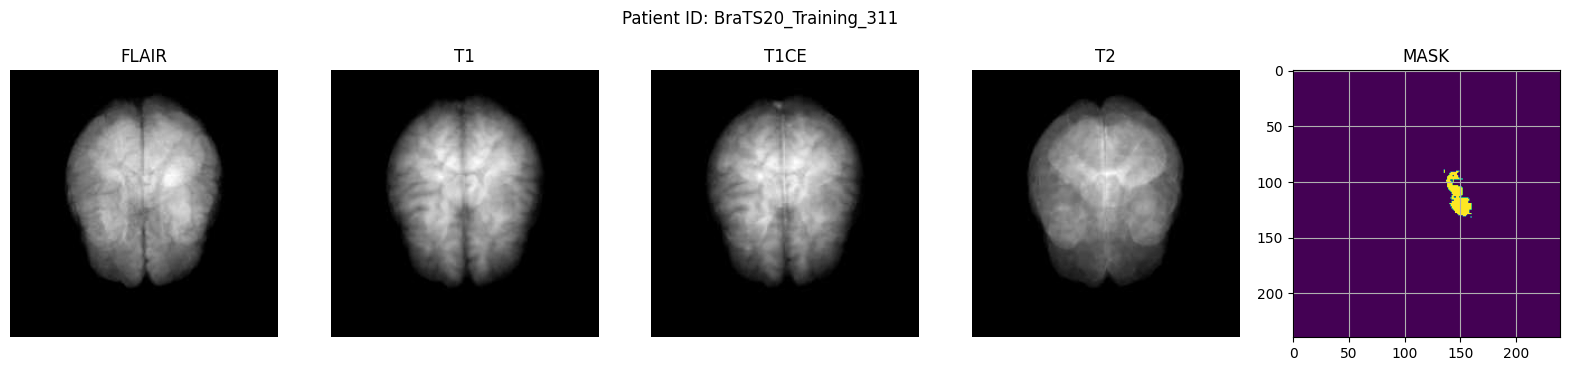

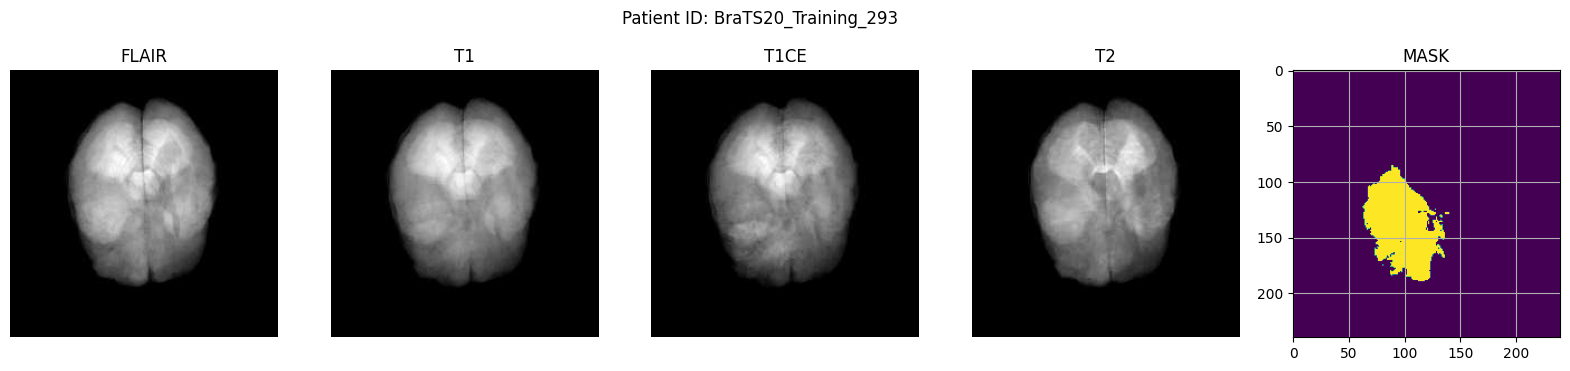

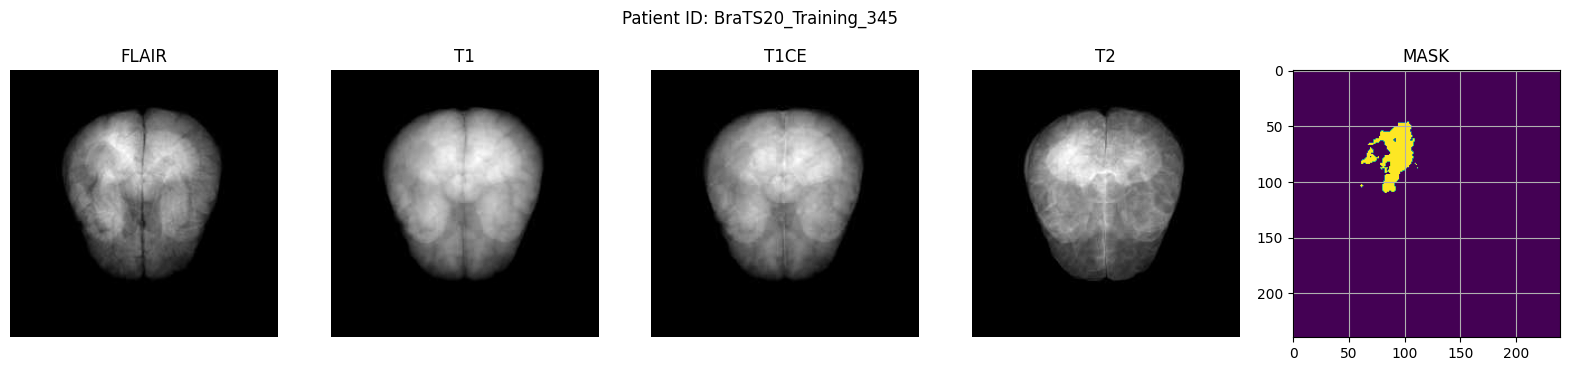

In [16]:
def visualize_samples(dataset, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with one row and (len(modality_types) + 1) columns
        plt.figure(figsize=(20, 4))

        # Visualize all MRI modalities in the first len(modality_types) columns
        for j in range(len(modality_types)):
            plt.subplot(1, len(modality_types) + 1, j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Visualize mask in the last column
        plt.subplot(1, len(modality_types) + 1, len(modality_types) + 1)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("MASK")

        plt.suptitle(f"Patient ID: {patient_id}")
        plt.show()

# Prikazivanje uzoraka u istom redu
visualize_samples(train_ds, modality_types, num_samples=3)

In [17]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024,2048)

        self.up0 = Up(2048,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up0(x6,x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [18]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     threshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               threshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= threshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [19]:
## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, threshold: float = 0.5):
        self.threshold: float = threshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

In [20]:
def bce_dice_loss(input, target, alpha, beta, smooth=1):
    # BCE loss
    bce_loss = F.binary_cross_entropy_with_logits(input, target)

    # Dice loss
    input = torch.sigmoid(input)
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    dice_loss = 1 - (2 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)

    # Combined loss
    loss = alpha * bce_loss + beta * dice_loss

    return loss

In [21]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 valid_dl: DataLoader,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9,0.999))
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : valid_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = bce_dice_loss(logits, targets, alpha=0.5, beta=0.5)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} \nValidation Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} \nValidation Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} \nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

In [22]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4).to(device)

In [23]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  valid_dl = valid_dl,
                  lr = 1e-5,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 40,
                 )

device: cuda


train epoch 1/40: 100%|██████████| 38/38 [07:02<00:00, 11.11s/it]


Loss: 0.6483 | Dice: 0.5510 | IoU: 0.3894


val epoch 1/40: 100%|██████████| 5/5 [00:49<00:00, 10.00s/it]


Loss: 0.6548 | Dice: 0.5482 | IoU: 0.3779


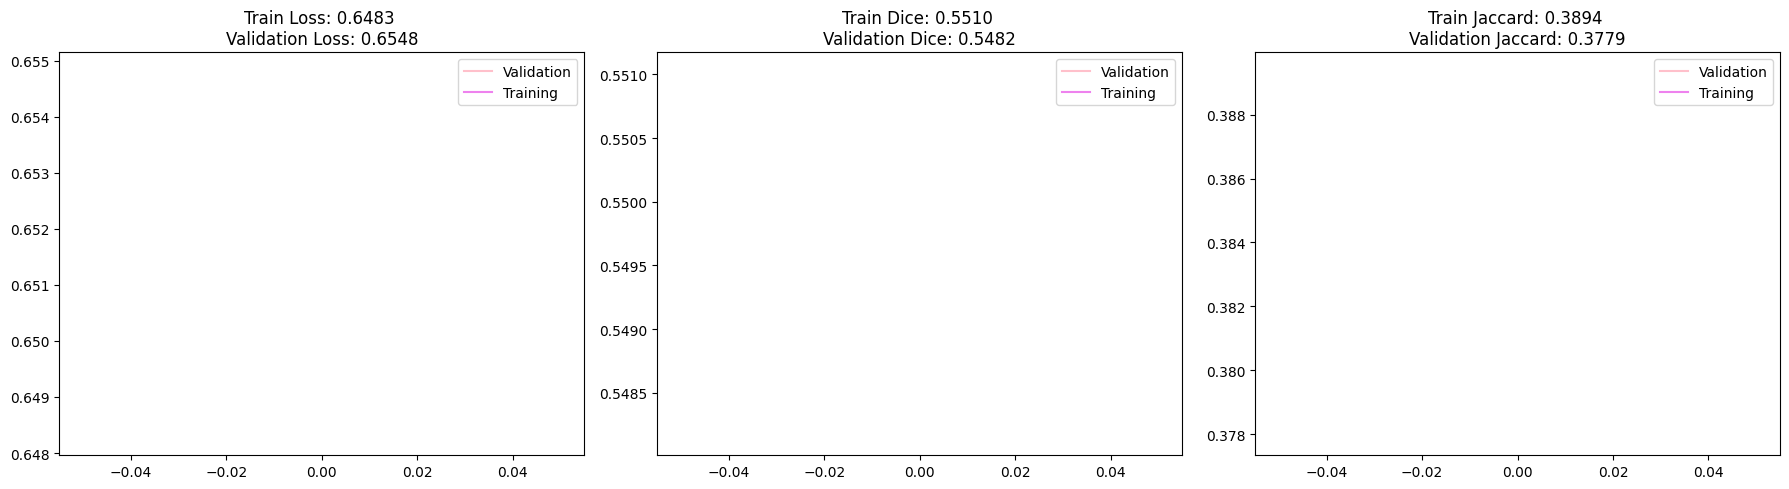

train epoch 2/40: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.6153 | Dice: 0.7431 | IoU: 0.5943


val epoch 2/40: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Loss: 0.6003 | Dice: 0.8088 | IoU: 0.6802


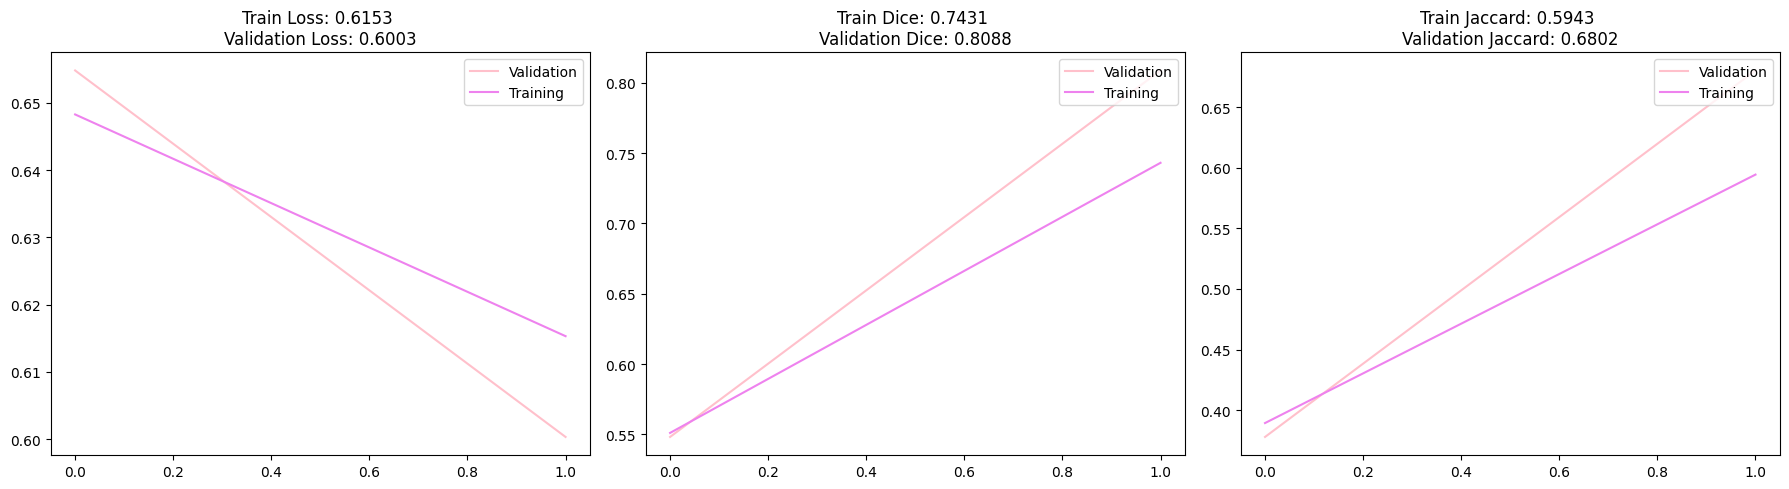

train epoch 3/40: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.5925 | Dice: 0.8169 | IoU: 0.6930


val epoch 3/40: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Loss: 0.5783 | Dice: 0.8474 | IoU: 0.7360


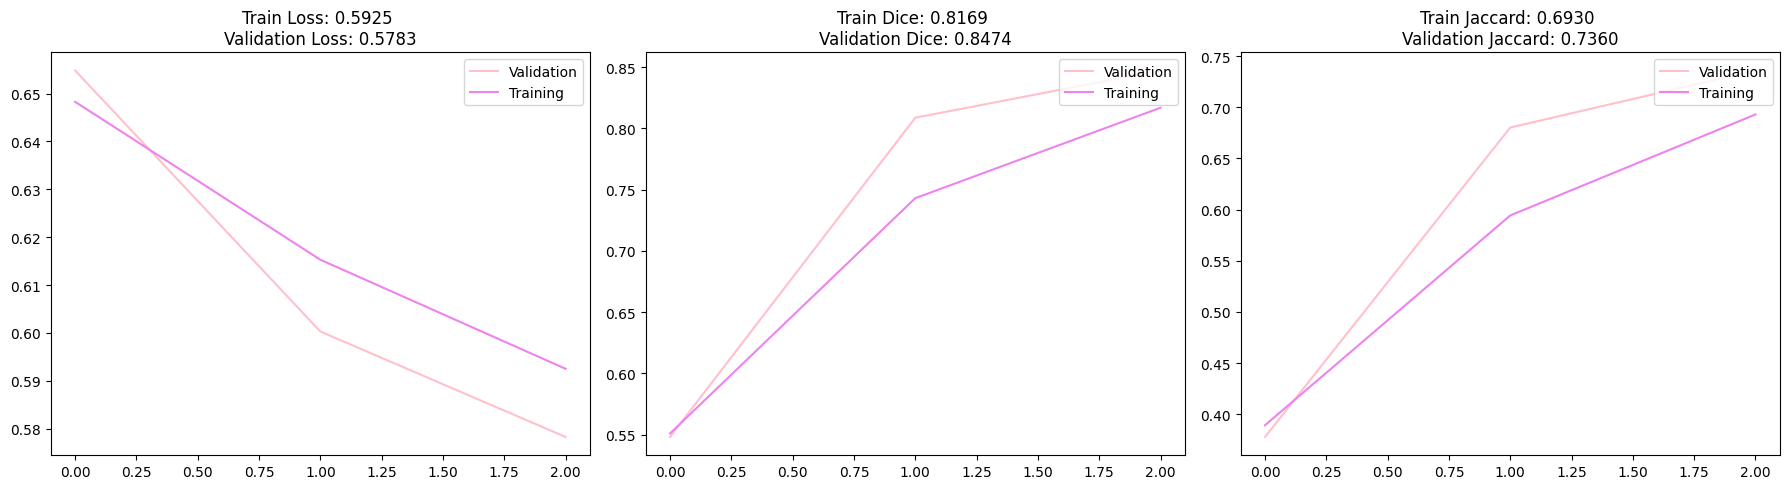

train epoch 4/40: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.5712 | Dice: 0.9049 | IoU: 0.8287


val epoch 4/40: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Loss: 0.5639 | Dice: 0.9364 | IoU: 0.8812


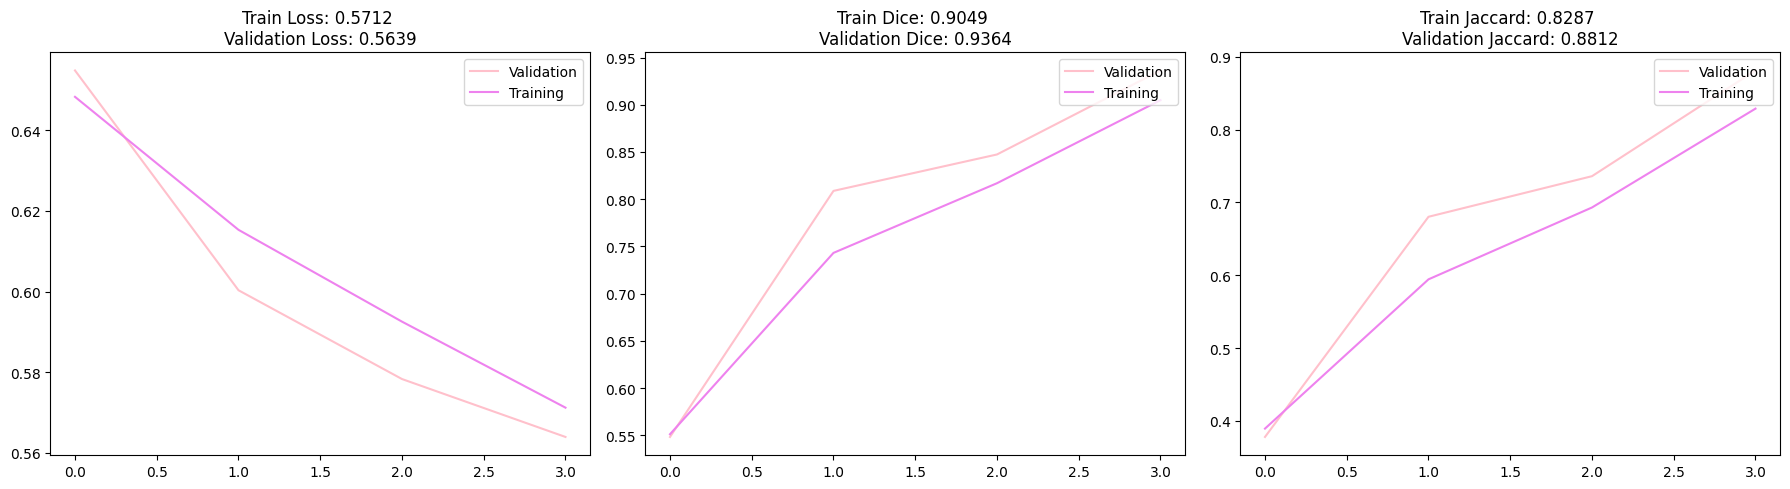

train epoch 5/40: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.5566 | Dice: 0.9495 | IoU: 0.9043


val epoch 5/40: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Loss: 0.5600 | Dice: 0.9378 | IoU: 0.8841


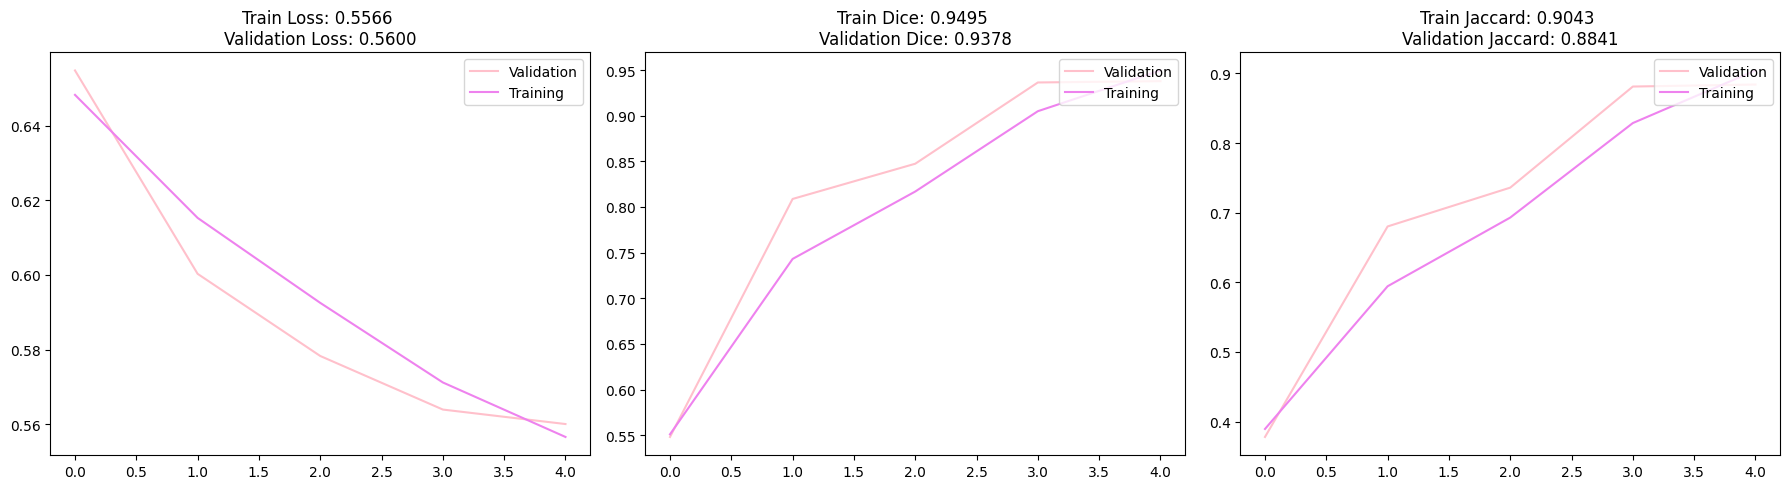

train epoch 6/40: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5474 | Dice: 0.9613 | IoU: 0.9257


val epoch 6/40: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Loss: 0.5426 | Dice: 0.9660 | IoU: 0.9345


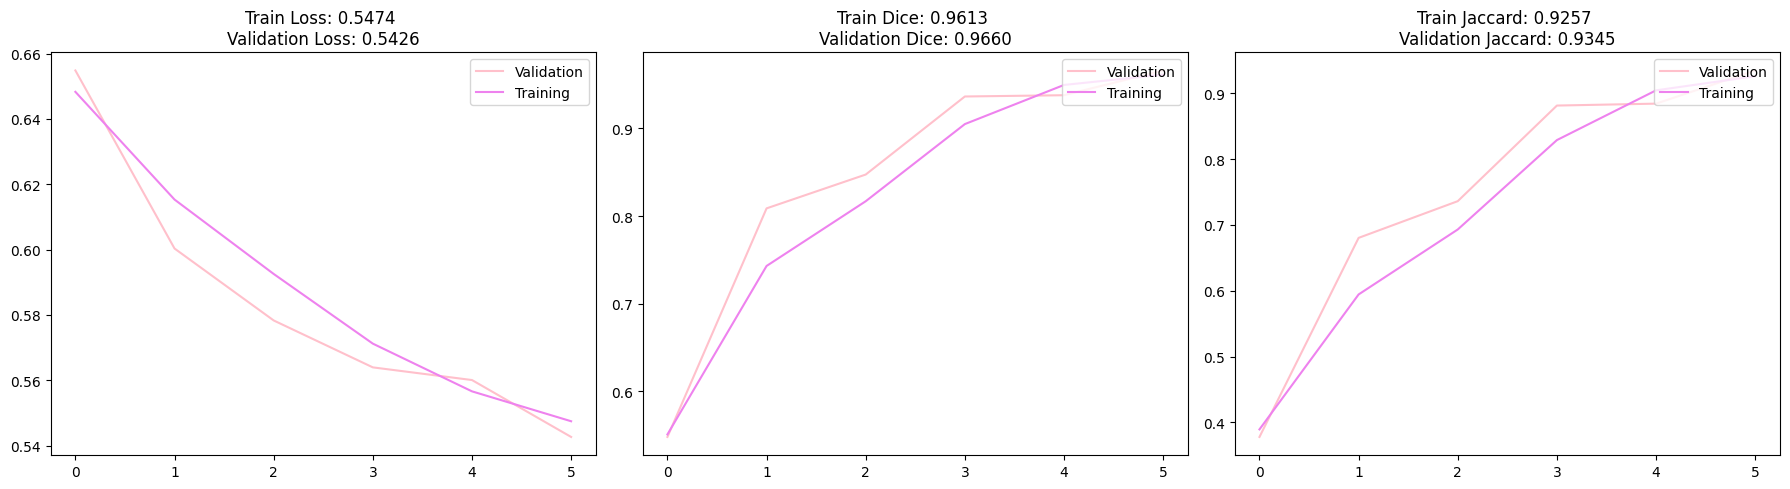

train epoch 7/40: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.5414 | Dice: 0.9672 | IoU: 0.9366


val epoch 7/40: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Loss: 0.5374 | Dice: 0.9685 | IoU: 0.9393


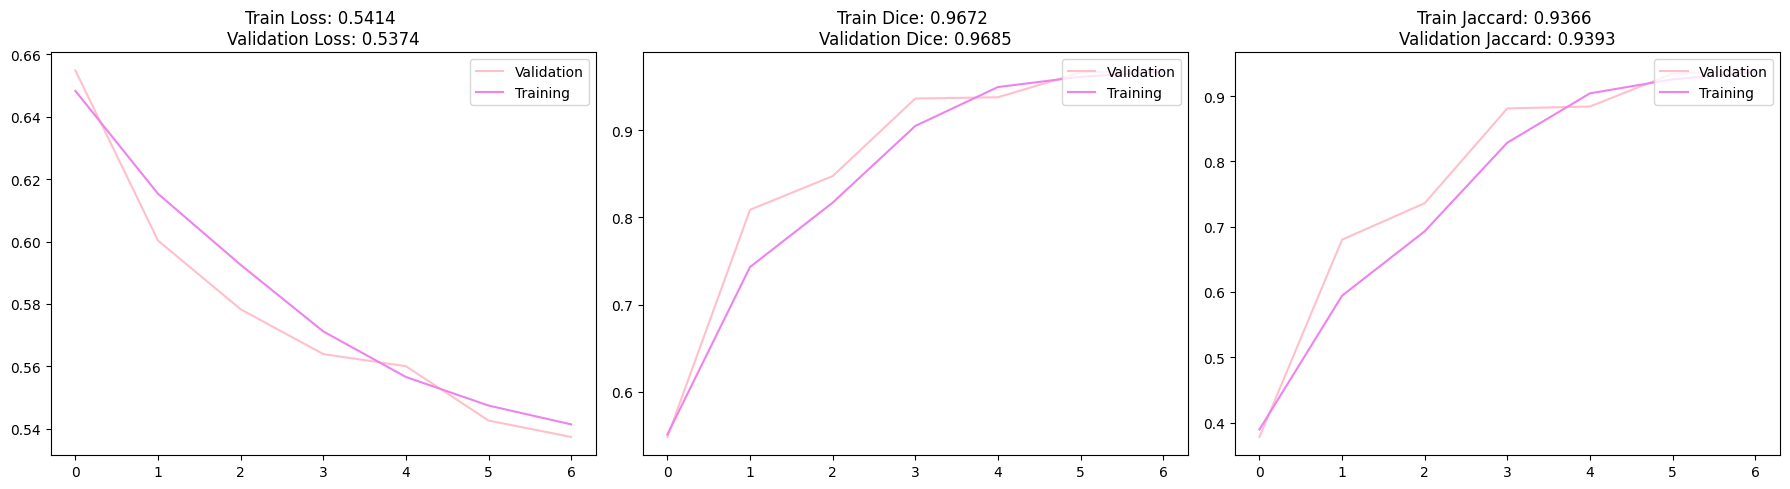

train epoch 8/40: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.5352 | Dice: 0.9721 | IoU: 0.9459


val epoch 8/40: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Loss: 0.5336 | Dice: 0.9699 | IoU: 0.9419


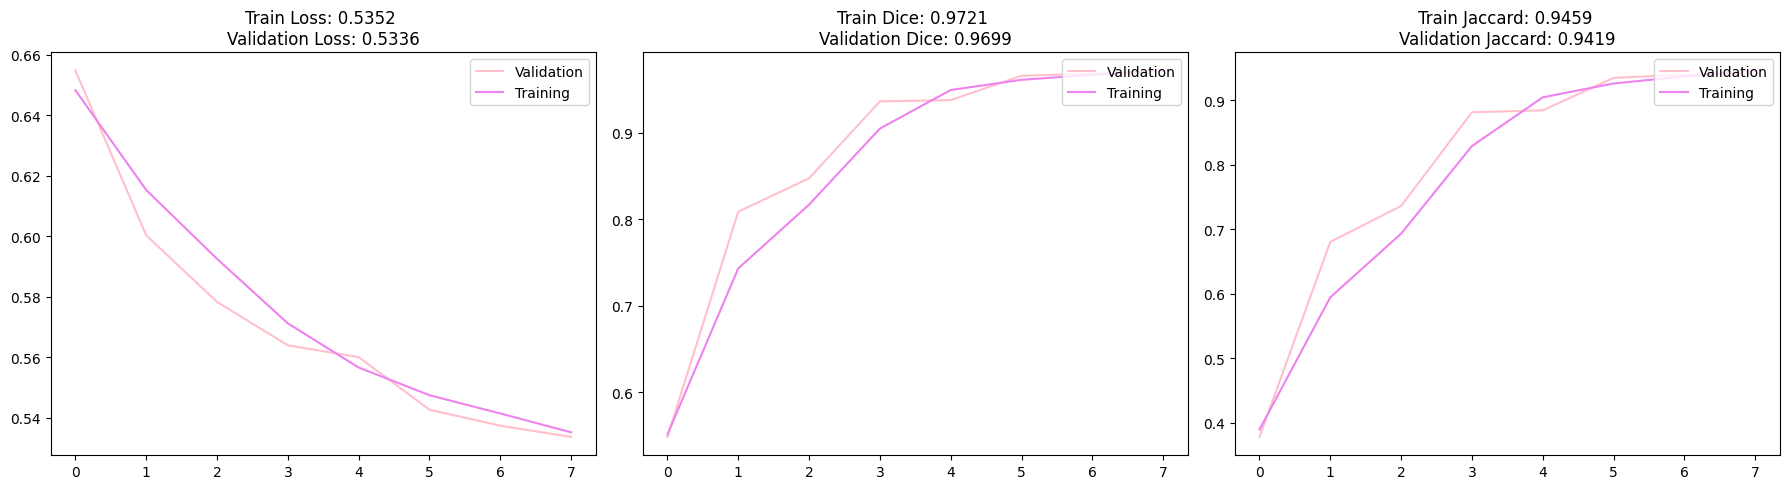

train epoch 9/40: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5299 | Dice: 0.9761 | IoU: 0.9535


val epoch 9/40: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Loss: 0.5278 | Dice: 0.9744 | IoU: 0.9503


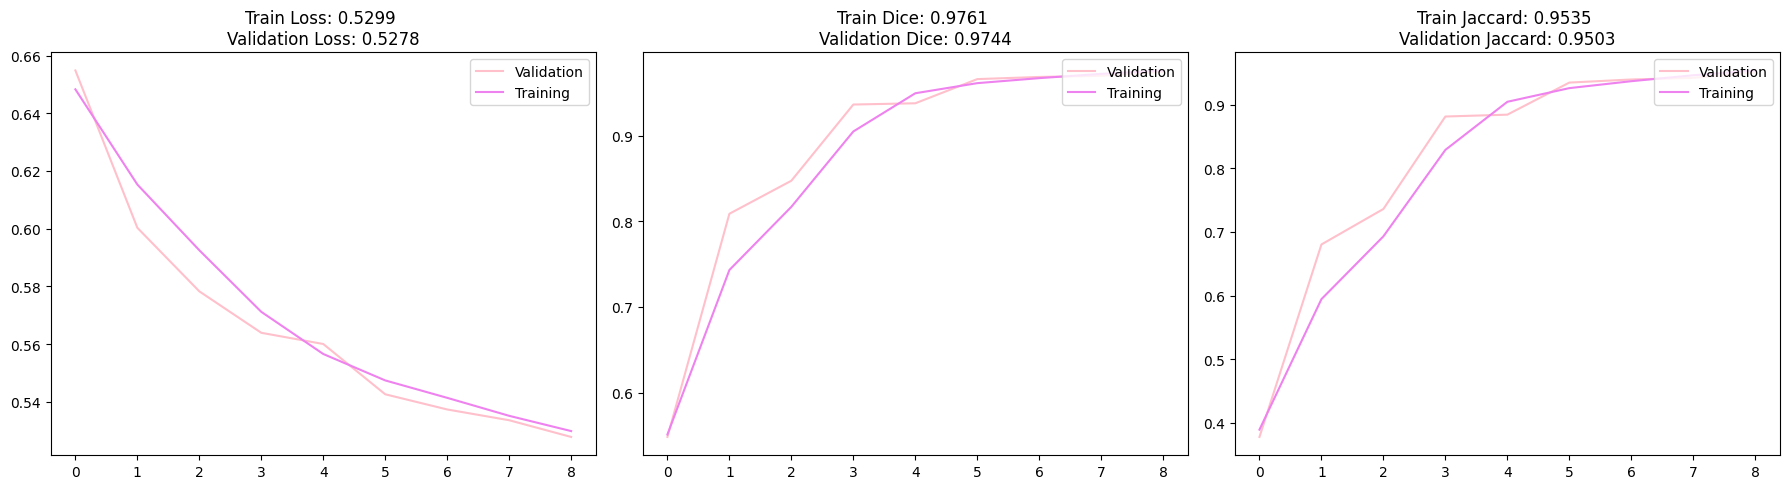

train epoch 10/40: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5257 | Dice: 0.9791 | IoU: 0.9592


val epoch 10/40: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Loss: 0.5253 | Dice: 0.9752 | IoU: 0.9521


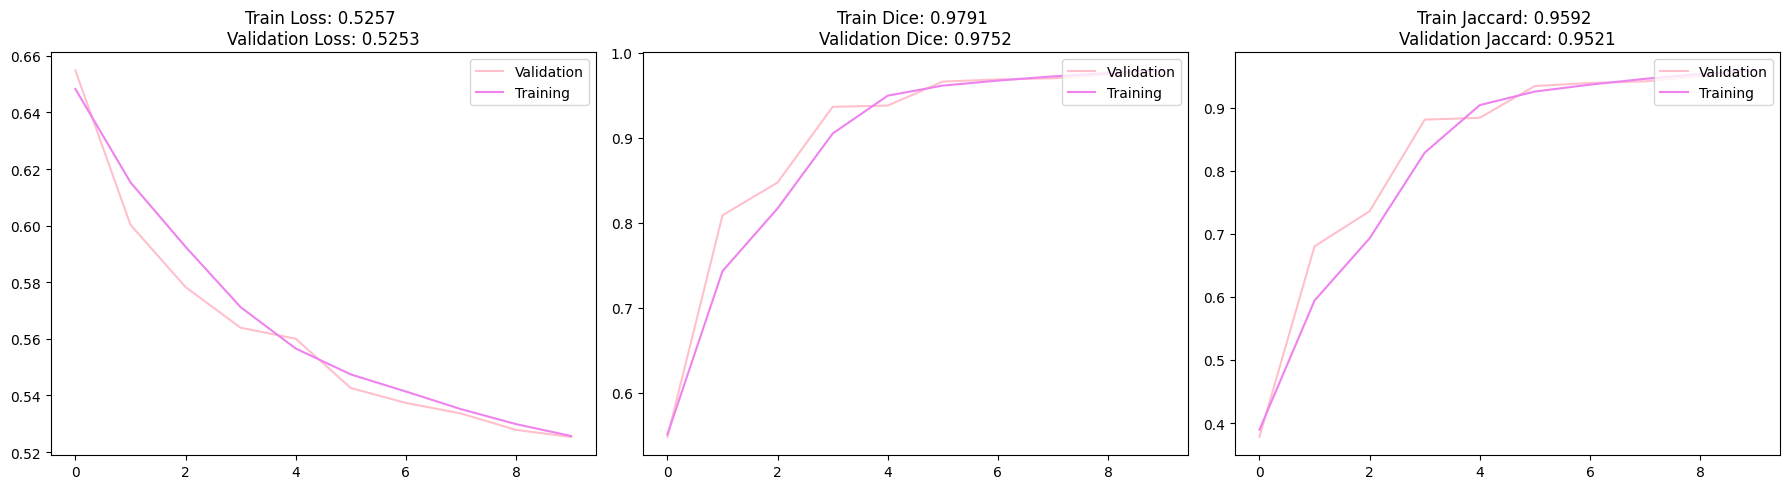

train epoch 11/40: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5220 | Dice: 0.9802 | IoU: 0.9613


val epoch 11/40: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Loss: 0.5192 | Dice: 0.9801 | IoU: 0.9612


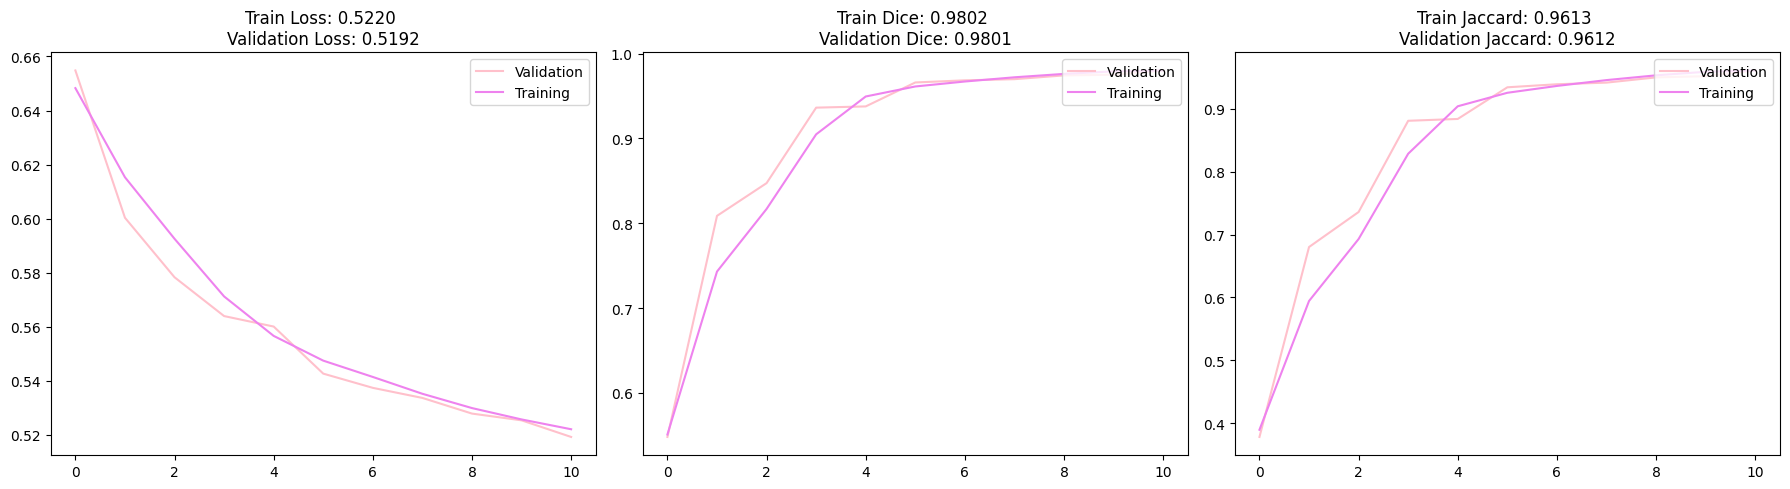

train epoch 12/40: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5175 | Dice: 0.9832 | IoU: 0.9670


val epoch 12/40: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Loss: 0.5189 | Dice: 0.9767 | IoU: 0.9548


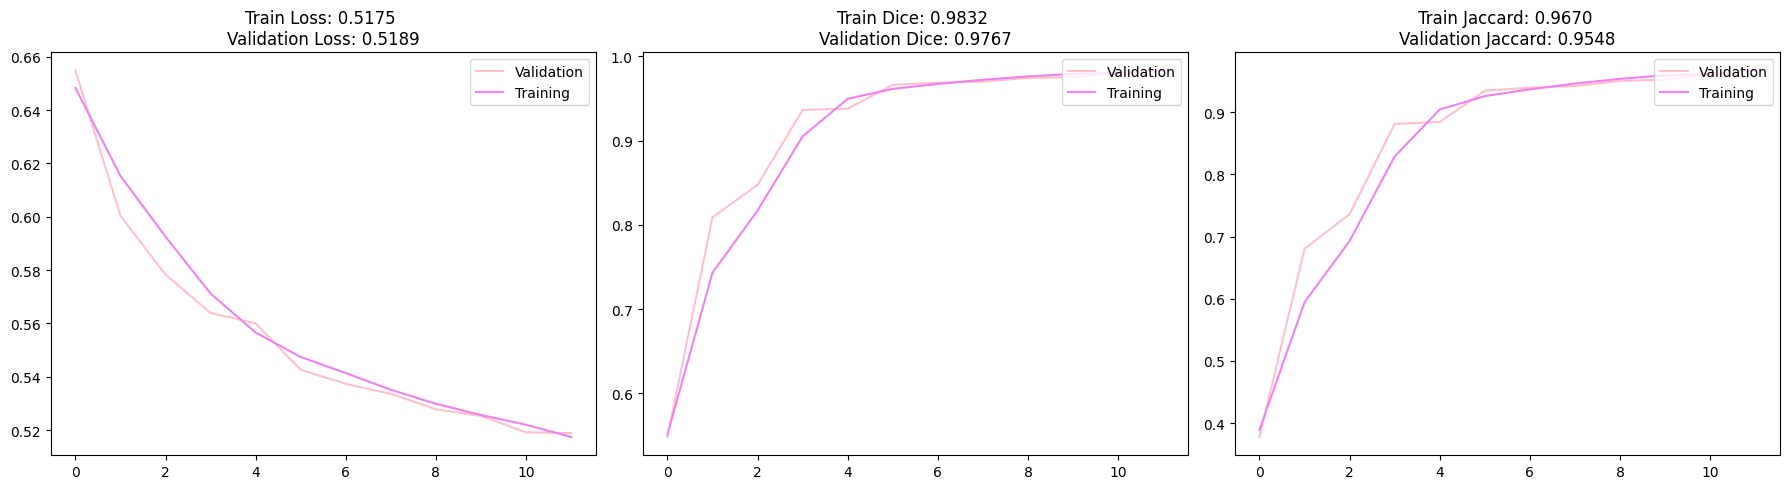

train epoch 13/40: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.5135 | Dice: 0.9827 | IoU: 0.9663


val epoch 13/40: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Loss: 0.5103 | Dice: 0.9854 | IoU: 0.9713


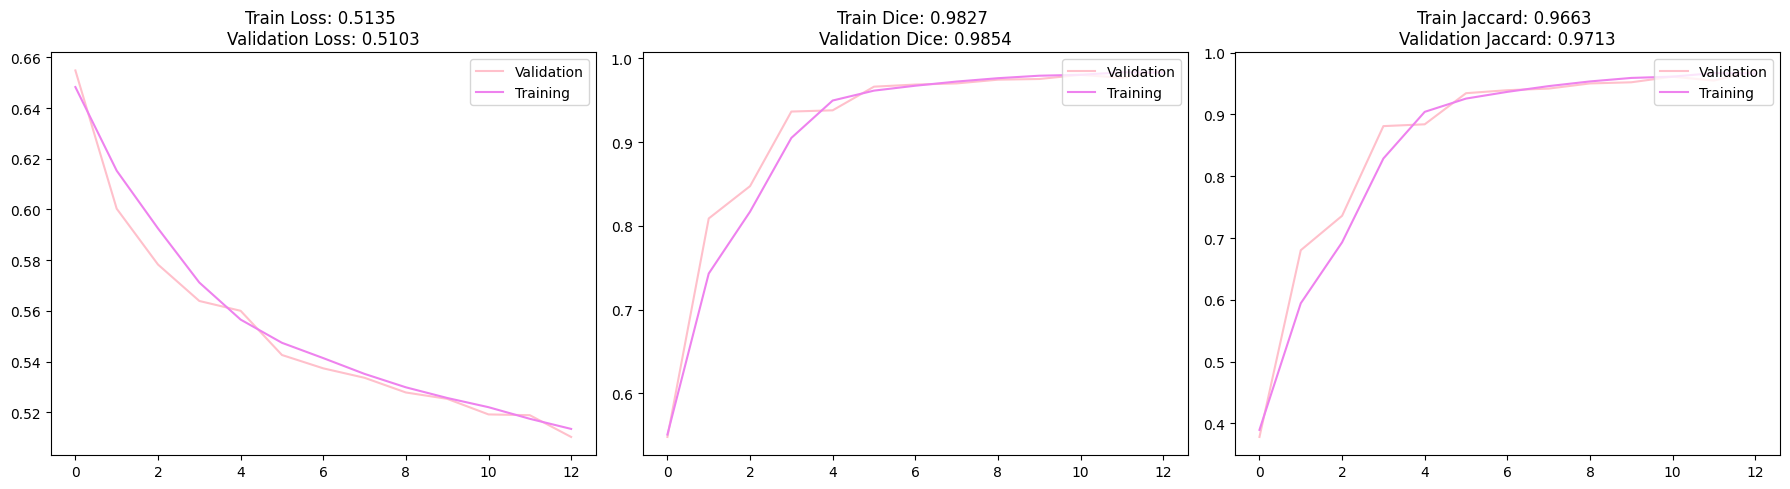

train epoch 14/40: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.5093 | Dice: 0.9849 | IoU: 0.9704


val epoch 14/40: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Loss: 0.5103 | Dice: 0.9803 | IoU: 0.9615


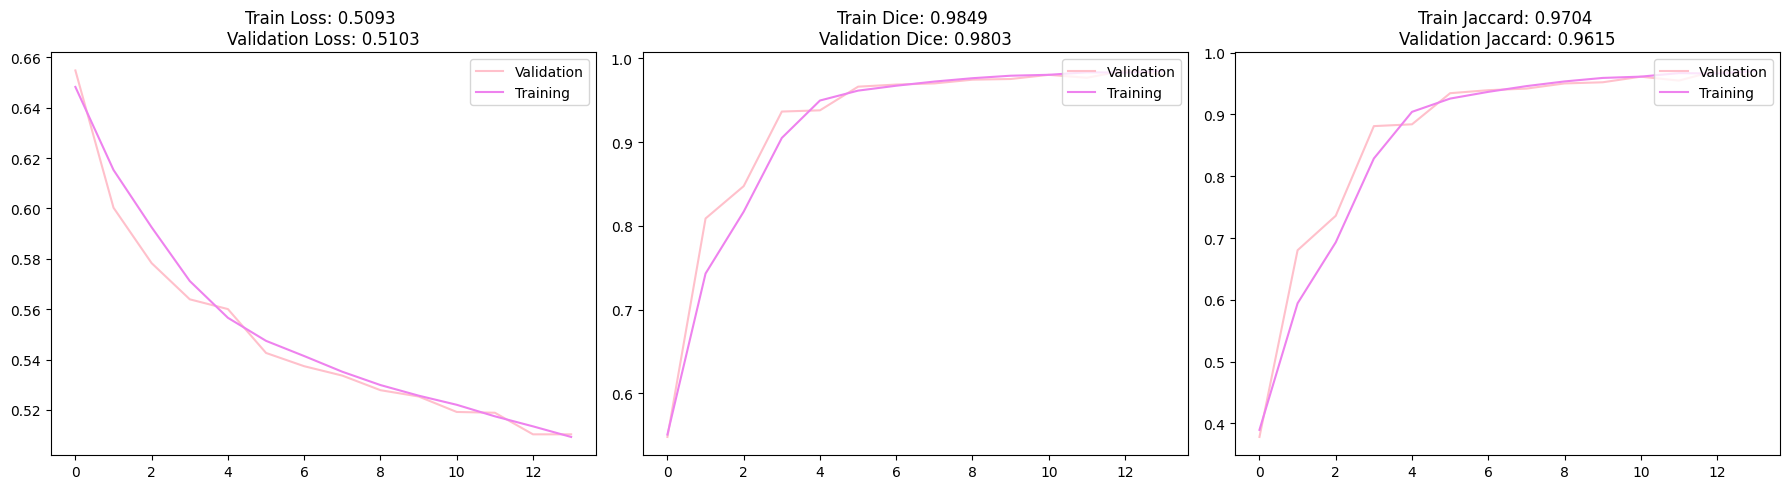

train epoch 15/40: 100%|██████████| 38/38 [00:30<00:00,  1.24it/s]


Loss: 0.5052 | Dice: 0.9859 | IoU: 0.9723


val epoch 15/40: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Loss: 0.5047 | Dice: 0.9840 | IoU: 0.9686


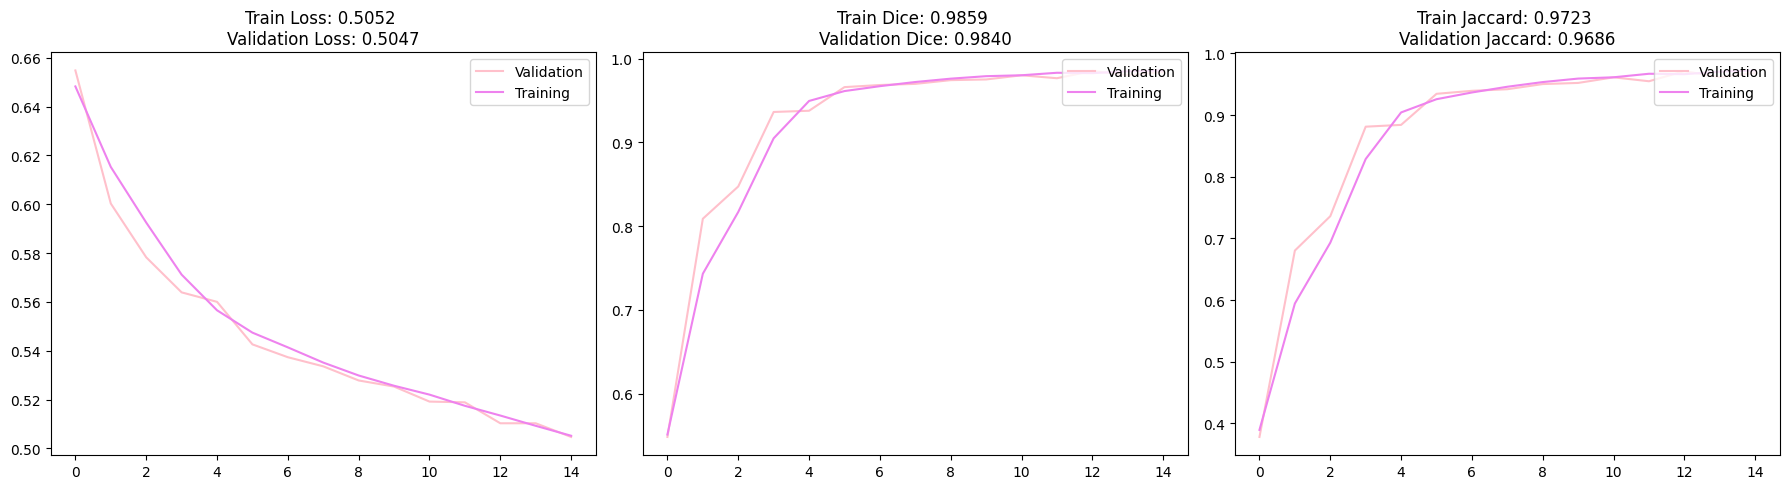

train epoch 16/40: 100%|██████████| 38/38 [00:31<00:00,  1.20it/s]


Loss: 0.5008 | Dice: 0.9877 | IoU: 0.9757


val epoch 16/40: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Loss: 0.5033 | Dice: 0.9808 | IoU: 0.9628


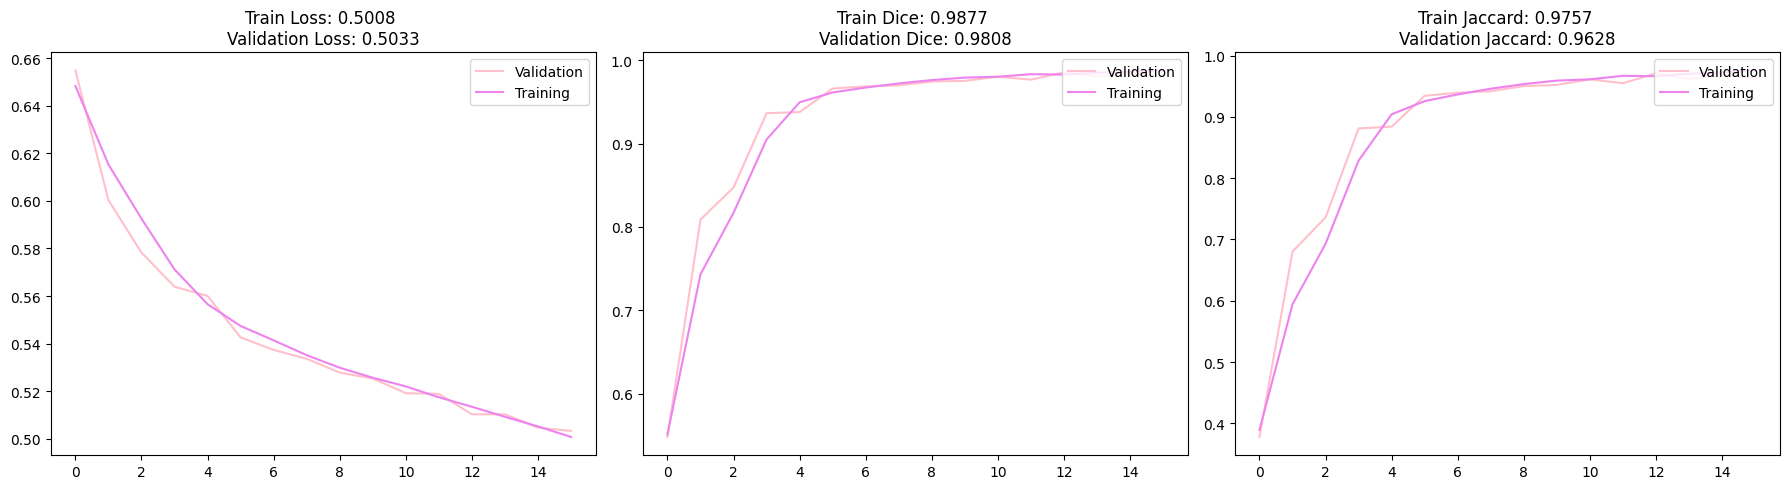

train epoch 17/40: 100%|██████████| 38/38 [00:29<00:00,  1.28it/s]


Loss: 0.4957 | Dice: 0.9878 | IoU: 0.9760


val epoch 17/40: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Loss: 0.4950 | Dice: 0.9856 | IoU: 0.9718


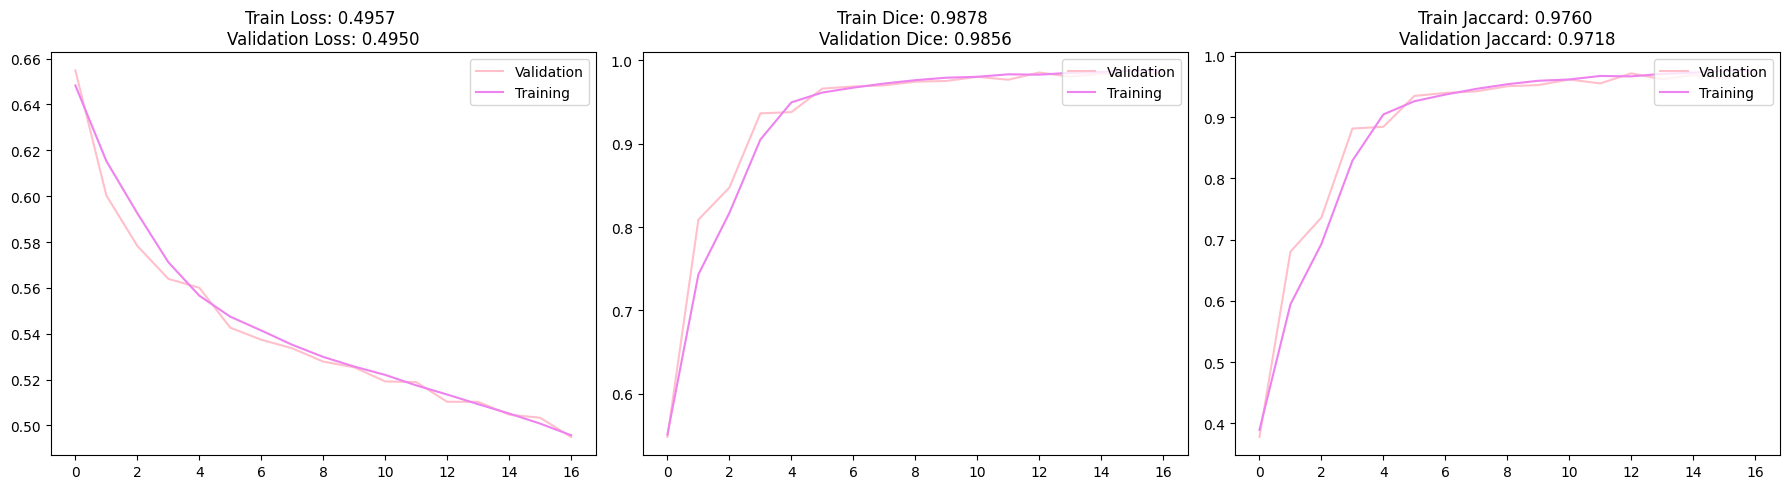

train epoch 18/40: 100%|██████████| 38/38 [00:29<00:00,  1.27it/s]


Loss: 0.4898 | Dice: 0.9885 | IoU: 0.9773


val epoch 18/40: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Loss: 0.4896 | Dice: 0.9789 | IoU: 0.9592


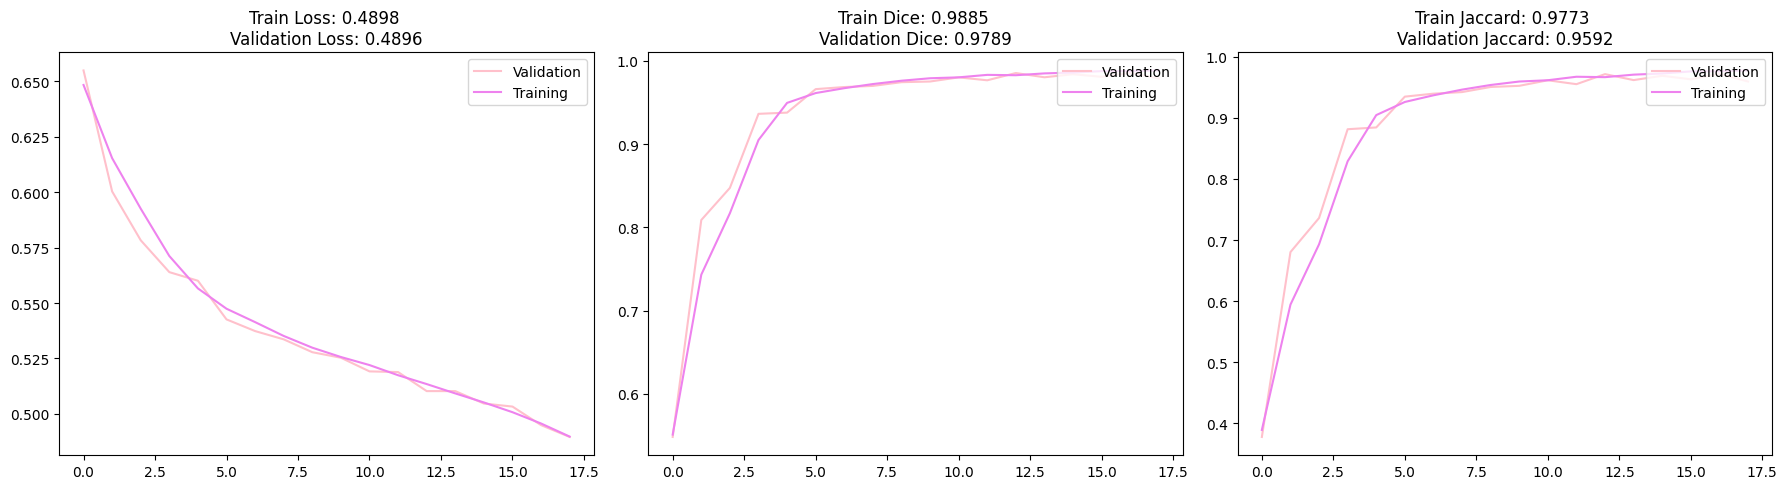

train epoch 19/40: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.4845 | Dice: 0.9884 | IoU: 0.9772


val epoch 19/40: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Loss: 0.4875 | Dice: 0.9810 | IoU: 0.9629


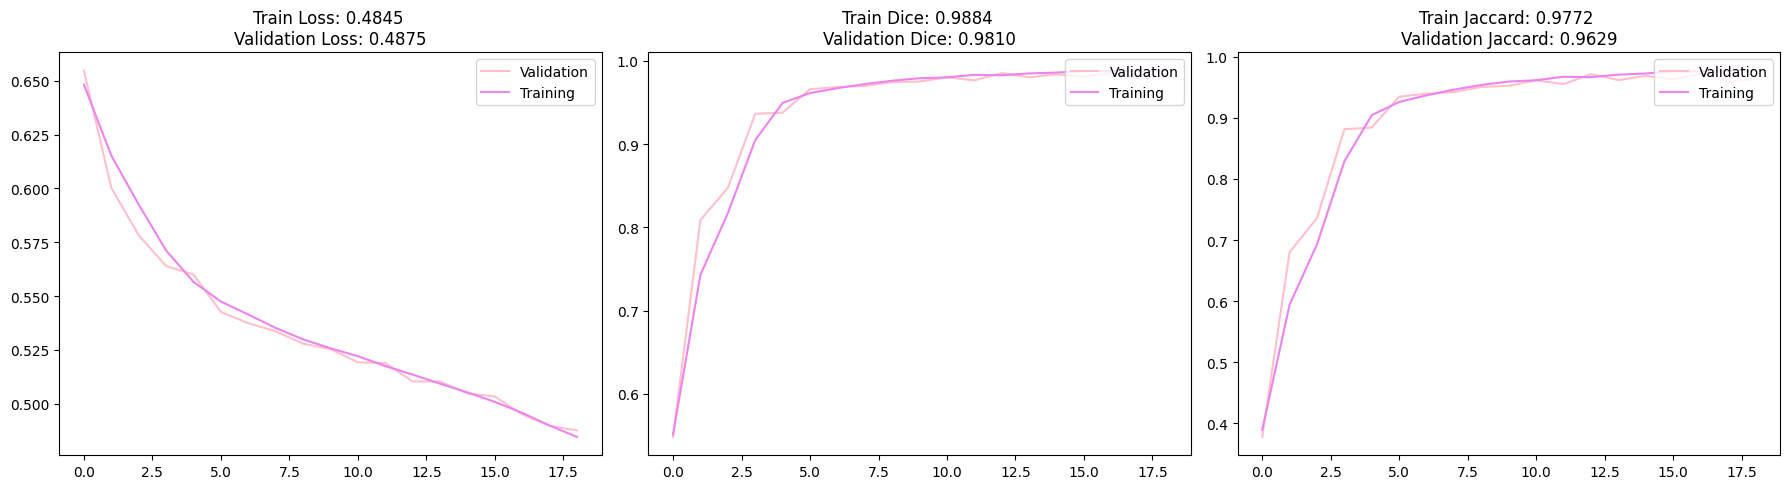

train epoch 20/40: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.4802 | Dice: 0.9886 | IoU: 0.9775


val epoch 20/40: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Loss: 0.4793 | Dice: 0.9872 | IoU: 0.9748


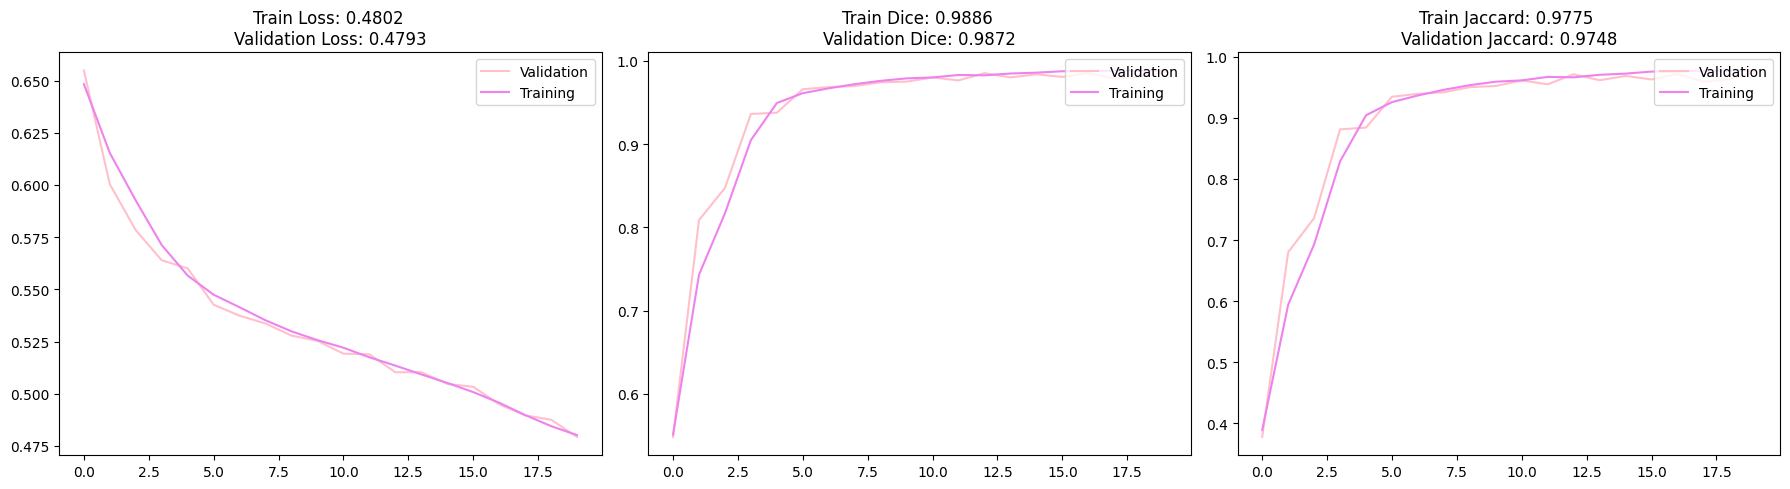

train epoch 21/40: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4759 | Dice: 0.9894 | IoU: 0.9791


val epoch 21/40: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Loss: 0.4761 | Dice: 0.9850 | IoU: 0.9706


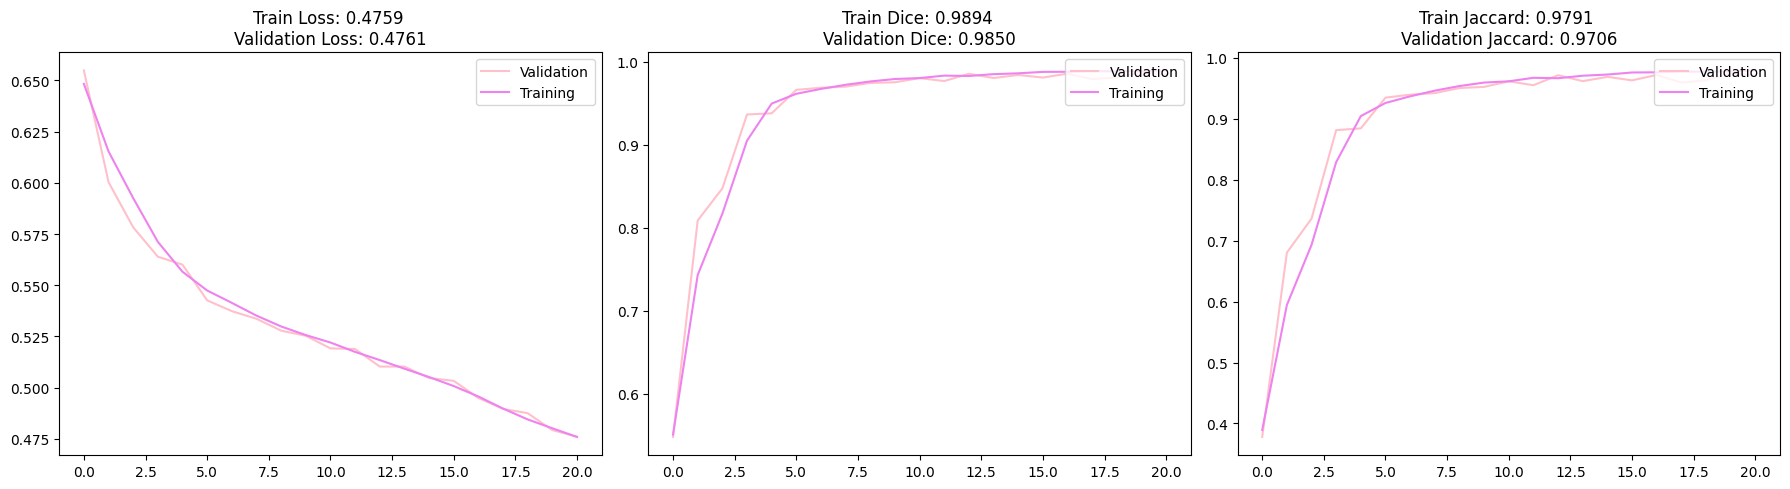

train epoch 22/40: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


Loss: 0.4736 | Dice: 0.9880 | IoU: 0.9764


val epoch 22/40: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Loss: 0.4777 | Dice: 0.9788 | IoU: 0.9588


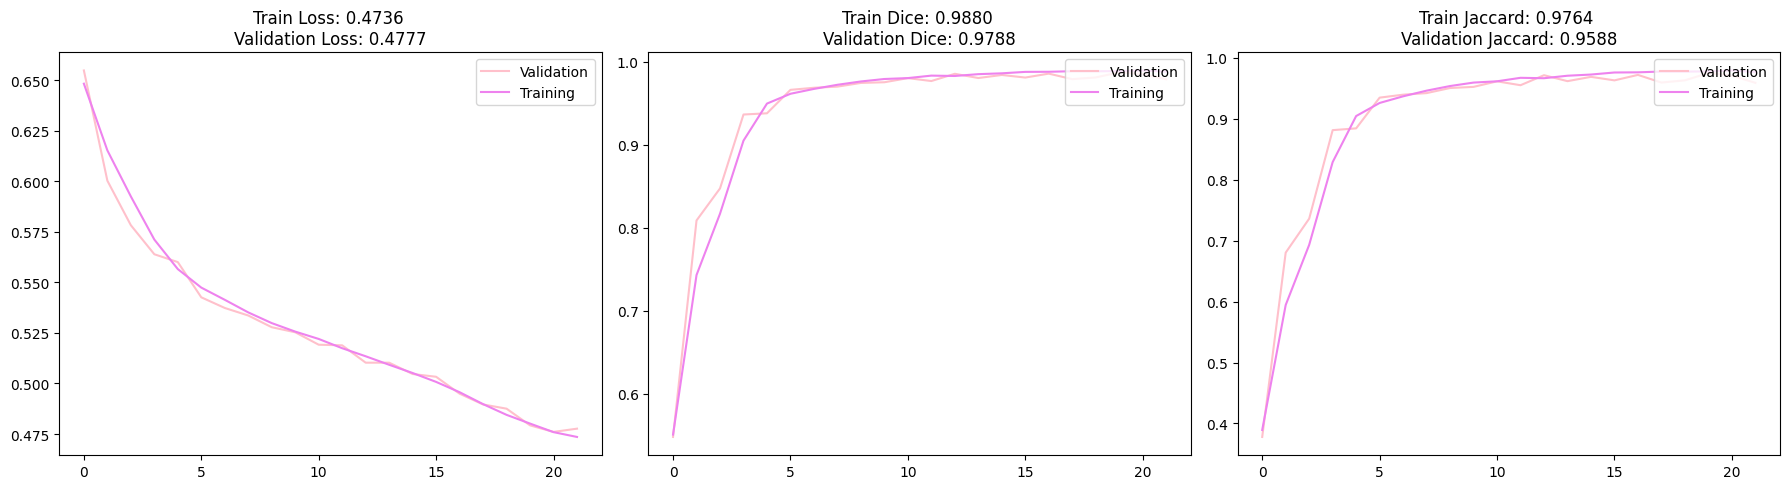

train epoch 23/40: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.4724 | Dice: 0.9836 | IoU: 0.9680


val epoch 23/40: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Loss: 0.4721 | Dice: 0.9821 | IoU: 0.9650


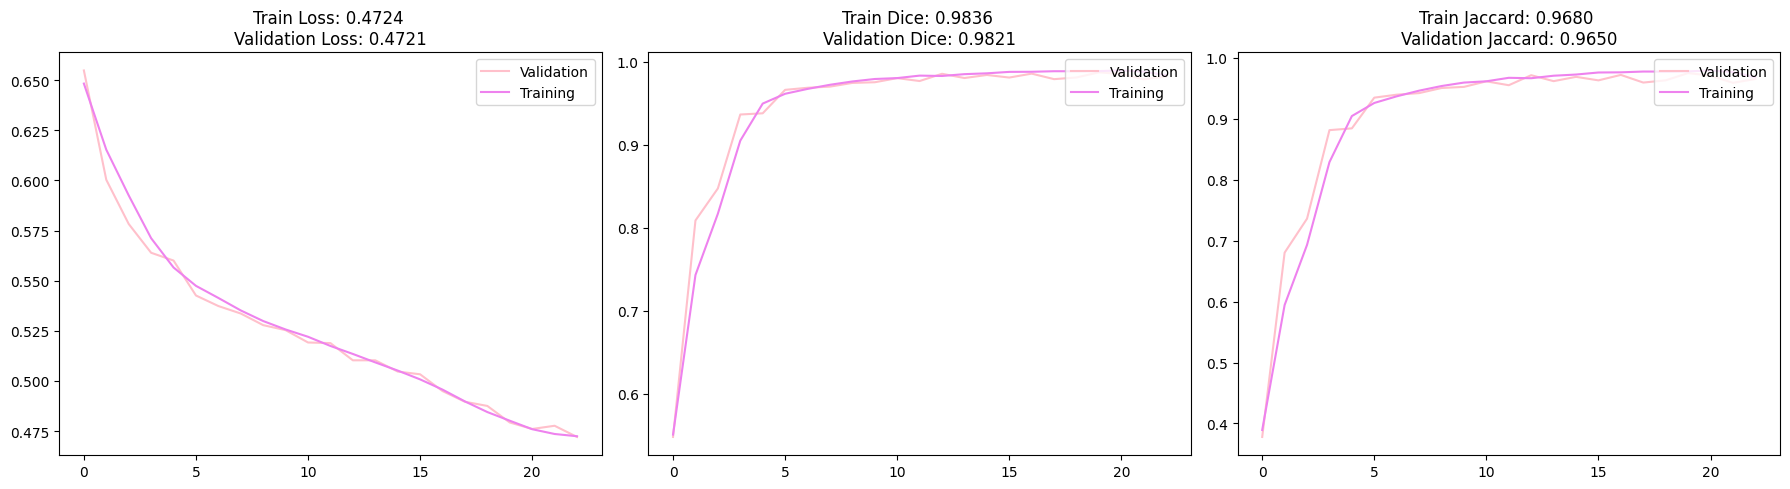

train epoch 24/40: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.4678 | Dice: 0.9872 | IoU: 0.9749


val epoch 24/40: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Loss: 0.4736 | Dice: 0.9729 | IoU: 0.9475


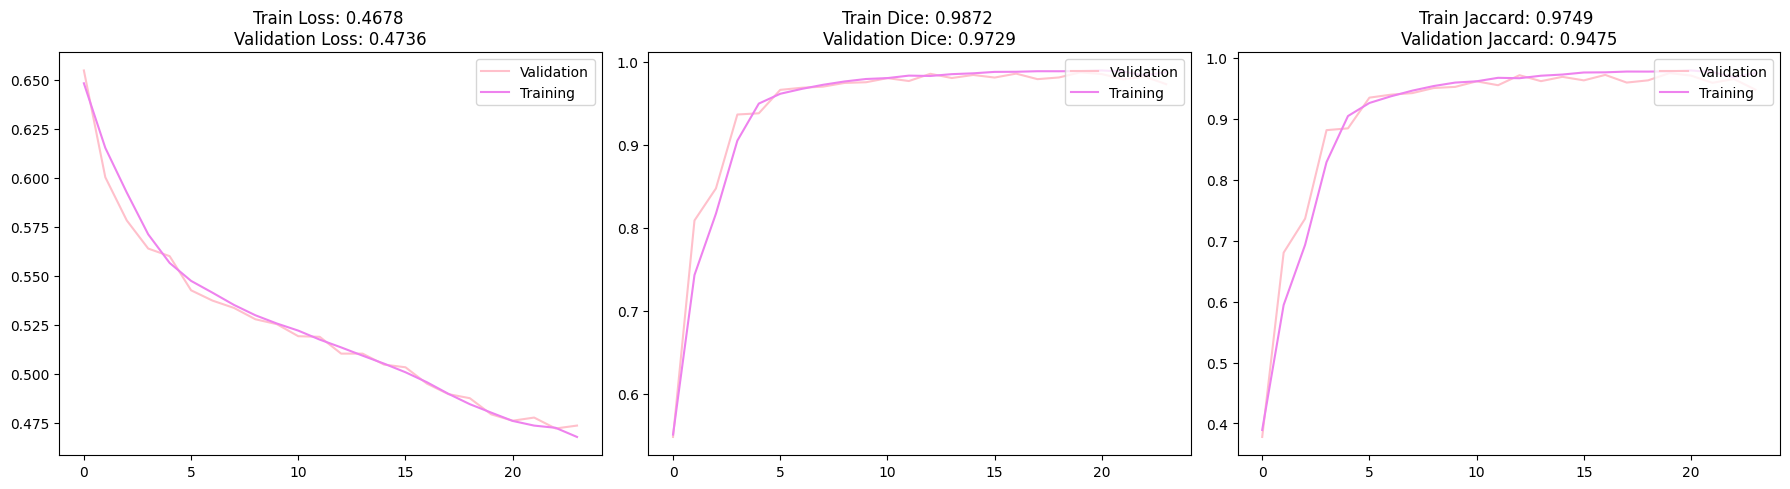

train epoch 25/40: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.4640 | Dice: 0.9880 | IoU: 0.9764


val epoch 25/40: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Loss: 0.4642 | Dice: 0.9840 | IoU: 0.9688


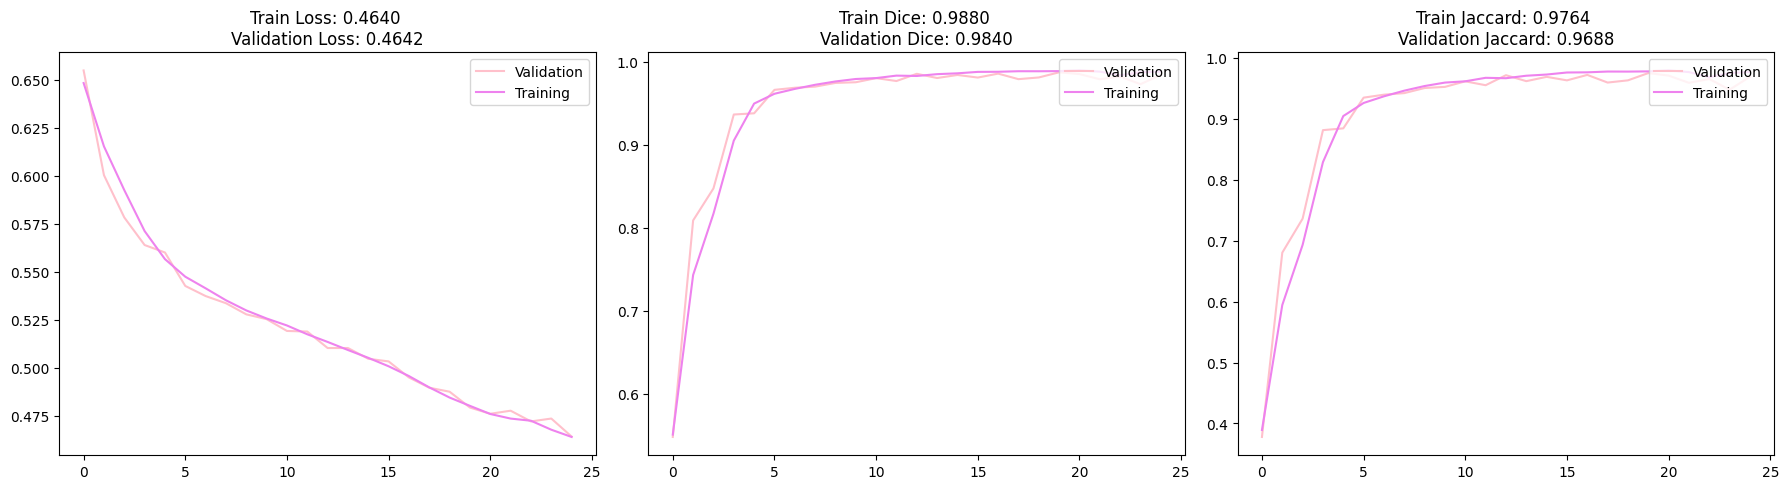

train epoch 26/40: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.4609 | Dice: 0.9880 | IoU: 0.9764


val epoch 26/40: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Loss: 0.4638 | Dice: 0.9803 | IoU: 0.9616


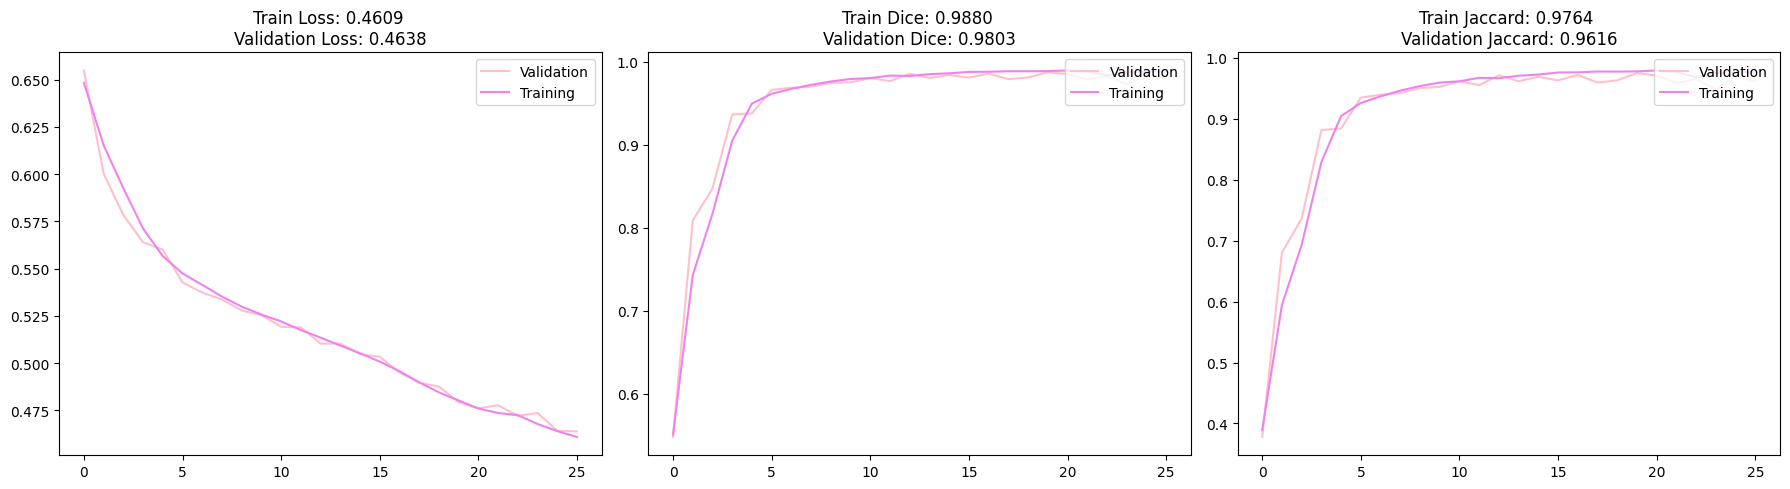

train epoch 27/40: 100%|██████████| 38/38 [00:30<00:00,  1.26it/s]


Loss: 0.4579 | Dice: 0.9886 | IoU: 0.9775


val epoch 27/40: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Loss: 0.4597 | Dice: 0.9796 | IoU: 0.9603


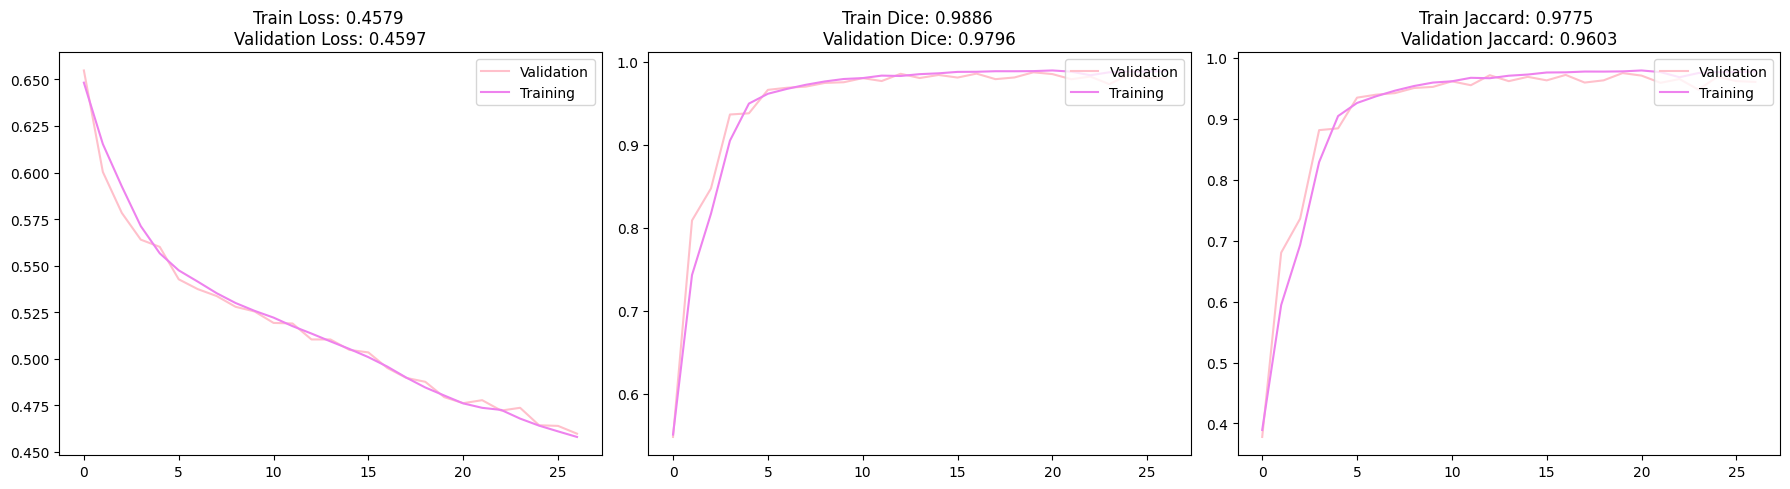

train epoch 28/40: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.4545 | Dice: 0.9897 | IoU: 0.9797


val epoch 28/40: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


Loss: 0.4557 | Dice: 0.9850 | IoU: 0.9706


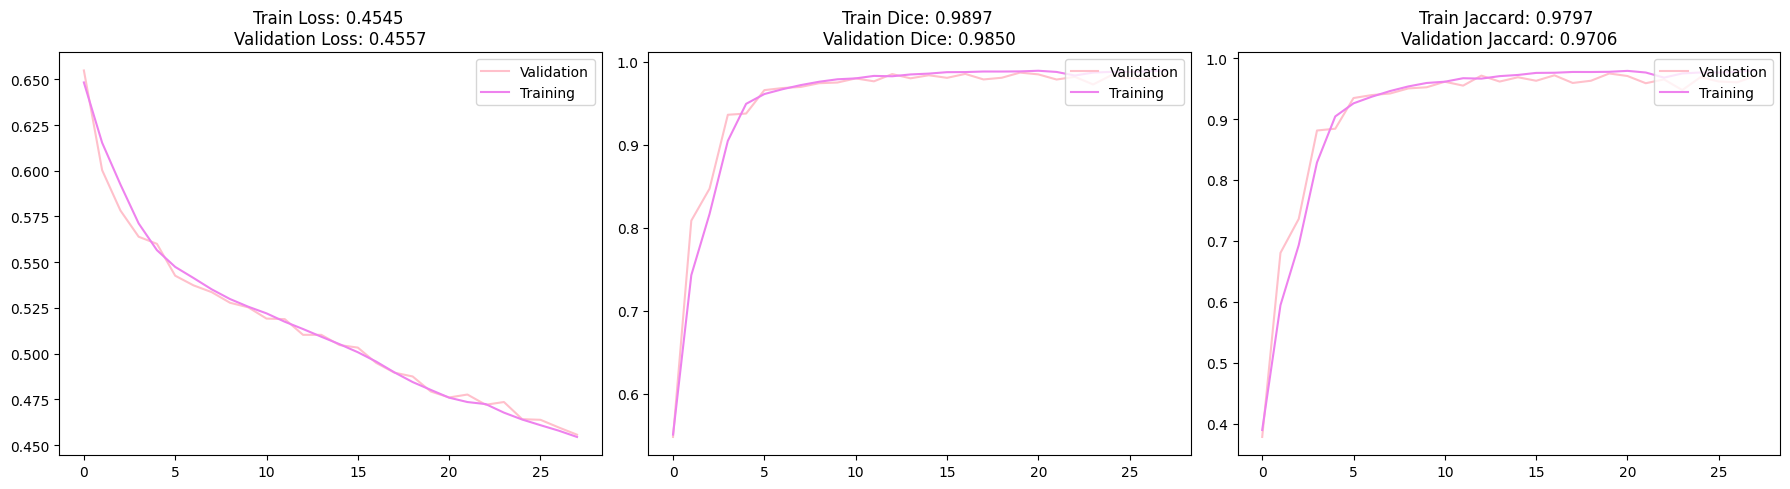

train epoch 29/40: 100%|██████████| 38/38 [00:30<00:00,  1.27it/s]


Loss: 0.4512 | Dice: 0.9900 | IoU: 0.9803


val epoch 29/40: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Loss: 0.4533 | Dice: 0.9828 | IoU: 0.9665


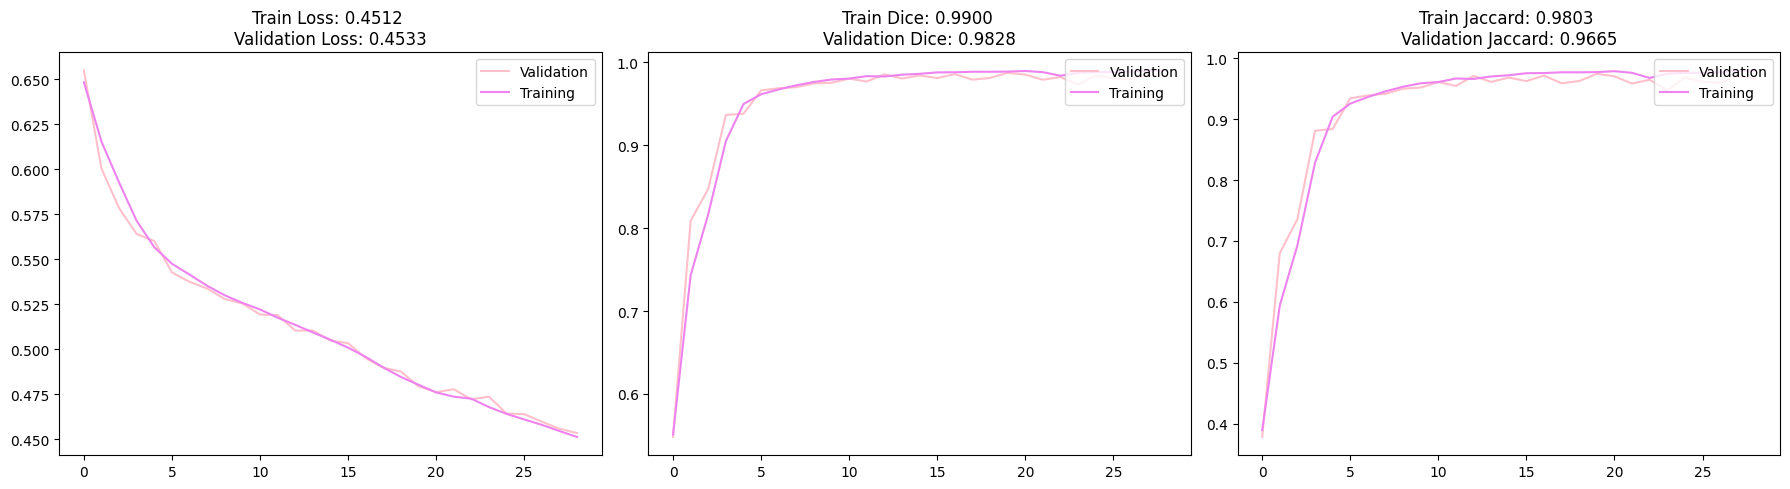

train epoch 30/40: 100%|██████████| 38/38 [00:29<00:00,  1.27it/s]


Loss: 0.4484 | Dice: 0.9901 | IoU: 0.9805


val epoch 30/40: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Loss: 0.4486 | Dice: 0.9850 | IoU: 0.9705


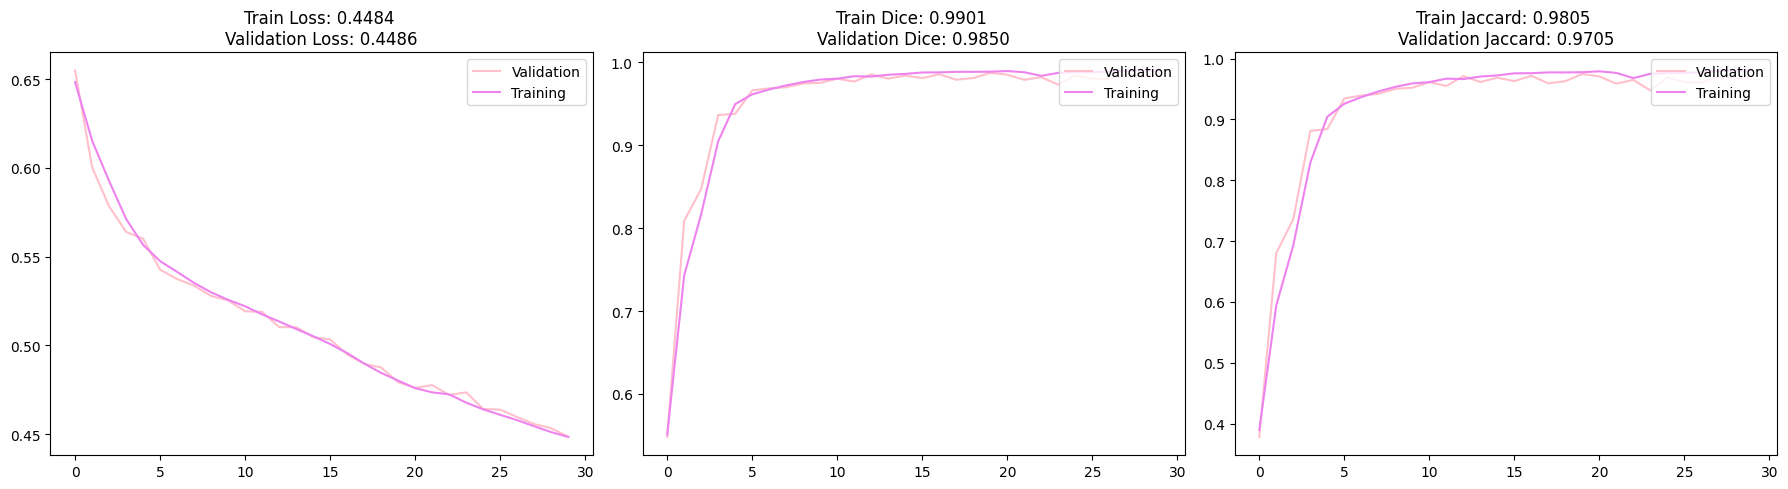

train epoch 31/40: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


Loss: 0.4456 | Dice: 0.9904 | IoU: 0.9811


val epoch 31/40: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Loss: 0.4458 | Dice: 0.9870 | IoU: 0.9744


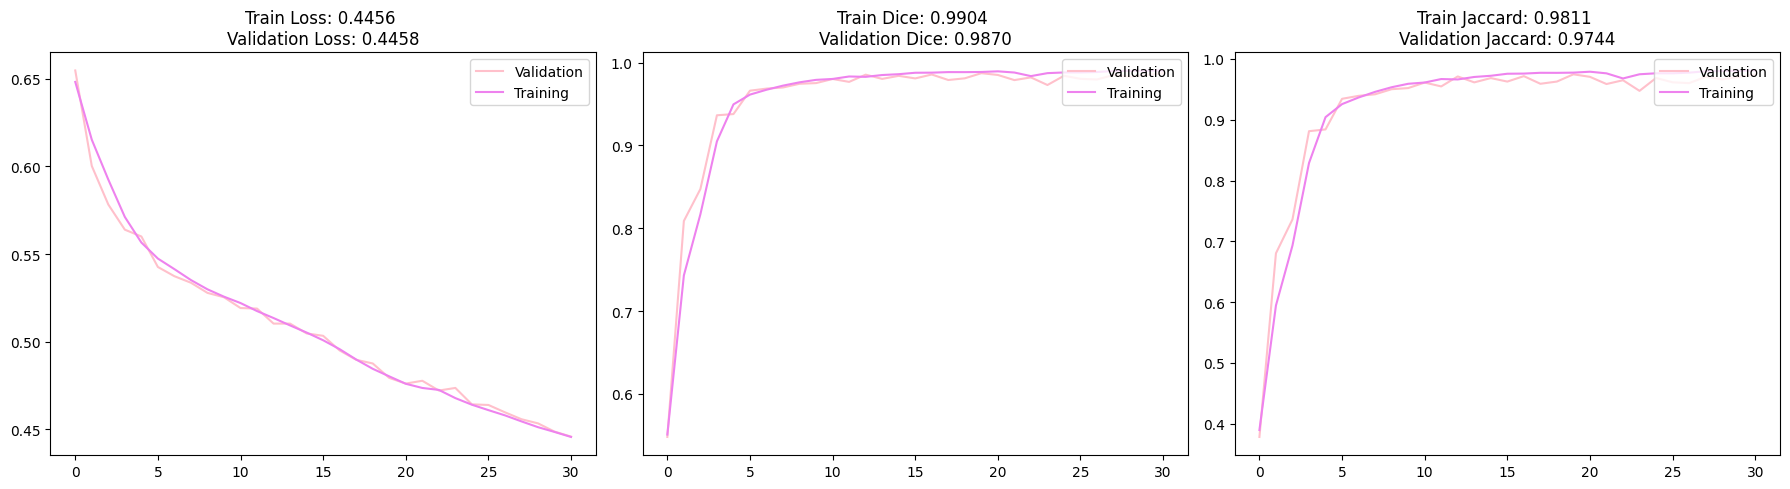

train epoch 32/40: 100%|██████████| 38/38 [00:29<00:00,  1.27it/s]


Loss: 0.4425 | Dice: 0.9907 | IoU: 0.9817


val epoch 32/40: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Loss: 0.4428 | Dice: 0.9868 | IoU: 0.9741


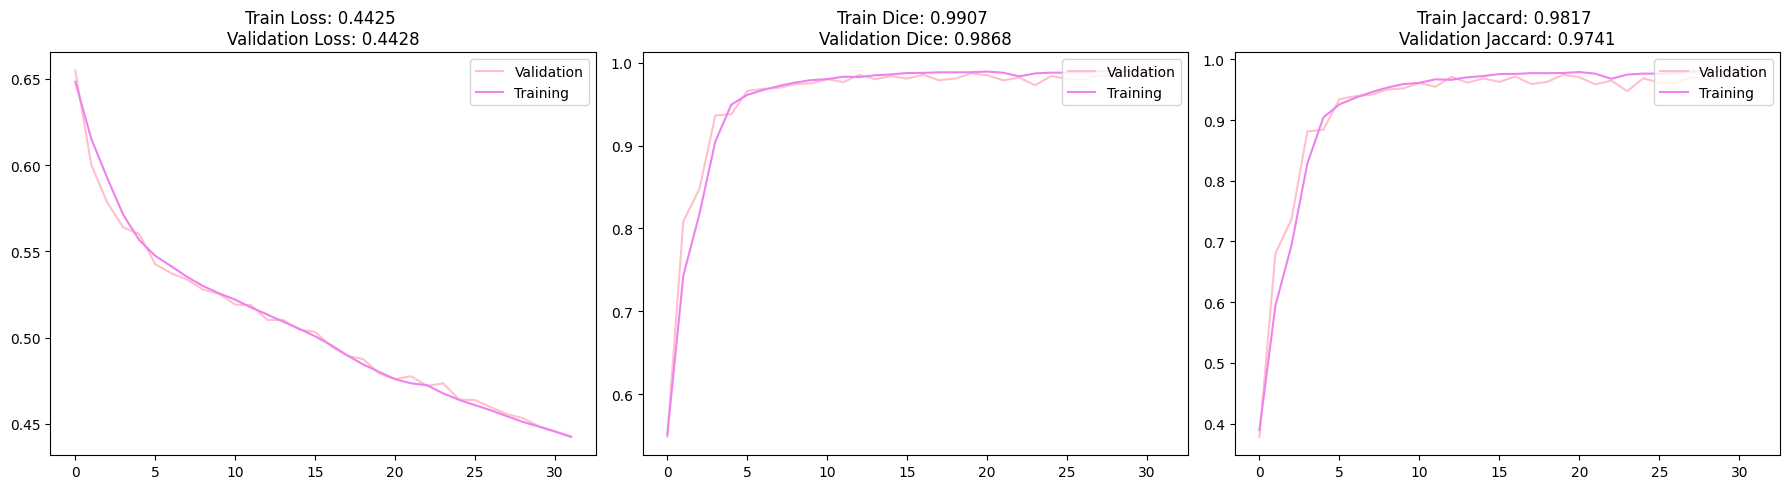

train epoch 33/40: 100%|██████████| 38/38 [00:29<00:00,  1.27it/s]


Loss: 0.4398 | Dice: 0.9905 | IoU: 0.9813


val epoch 33/40: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Loss: 0.4397 | Dice: 0.9873 | IoU: 0.9750


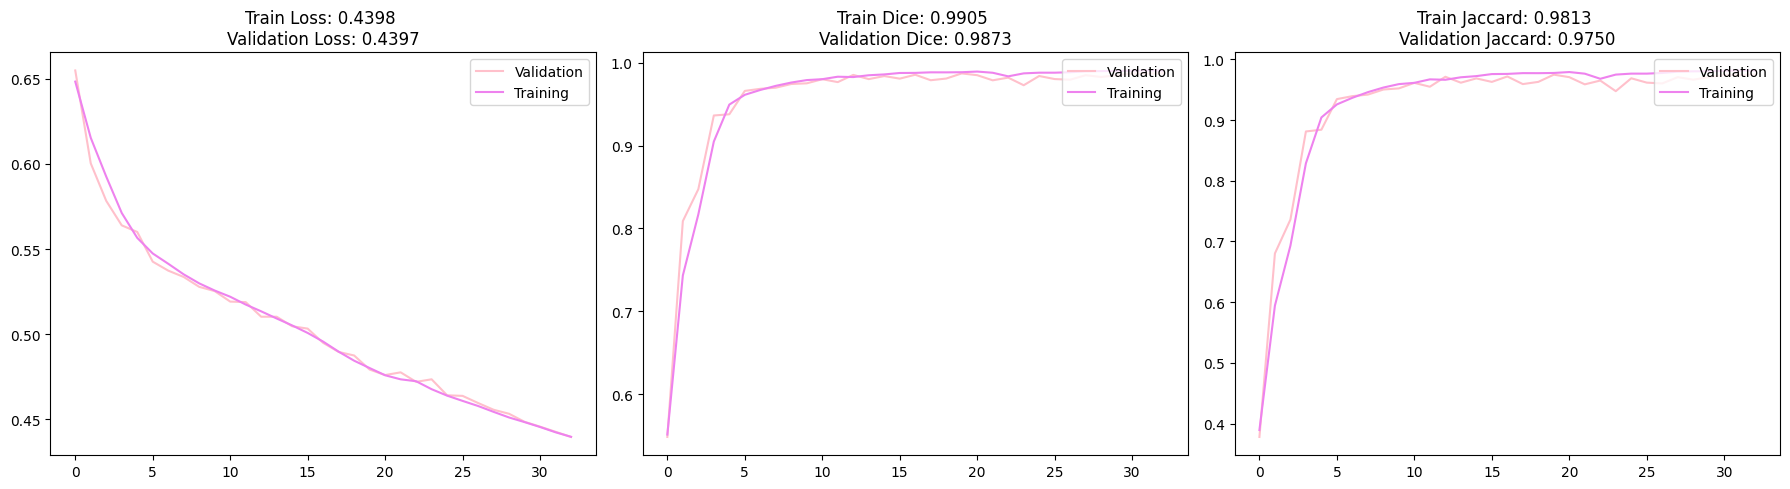

train epoch 34/40: 100%|██████████| 38/38 [00:29<00:00,  1.27it/s]


Loss: 0.4361 | Dice: 0.9916 | IoU: 0.9833


val epoch 34/40: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Loss: 0.4367 | Dice: 0.9877 | IoU: 0.9758


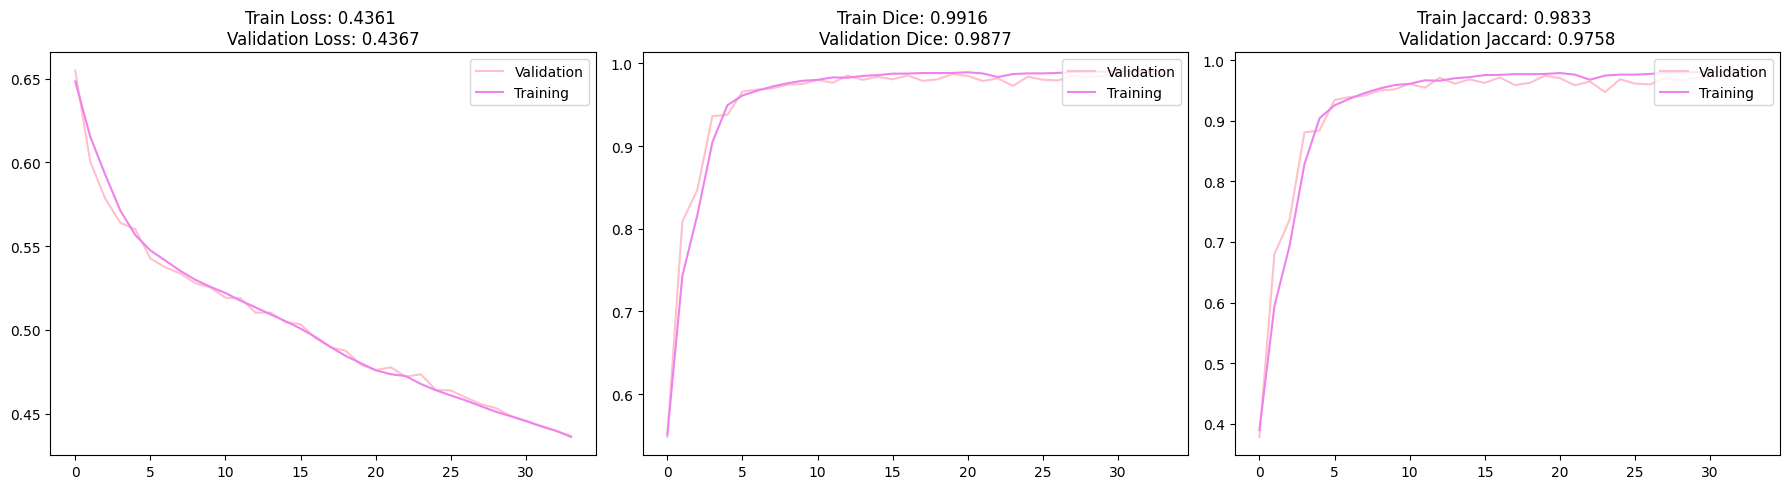

train epoch 35/40: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.4336 | Dice: 0.9913 | IoU: 0.9829


val epoch 35/40: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Loss: 0.4344 | Dice: 0.9842 | IoU: 0.9690


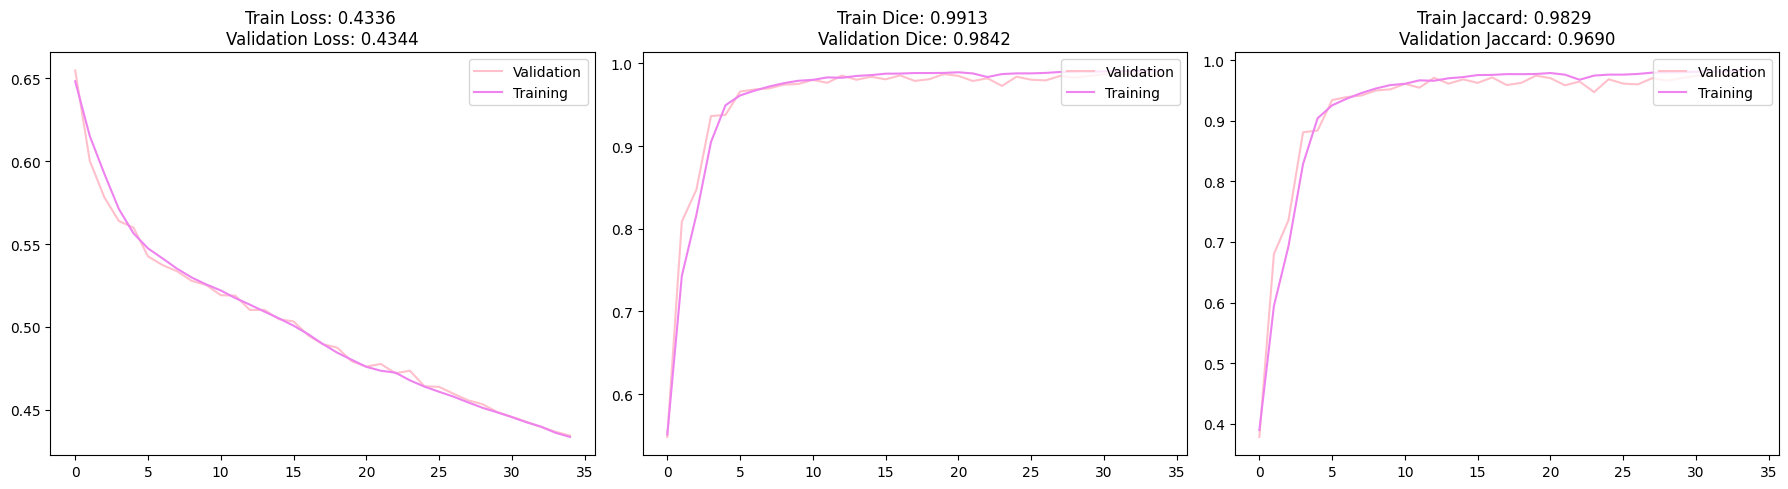

train epoch 36/40: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


Loss: 0.4302 | Dice: 0.9919 | IoU: 0.9839


val epoch 36/40: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


Loss: 0.4301 | Dice: 0.9883 | IoU: 0.9770


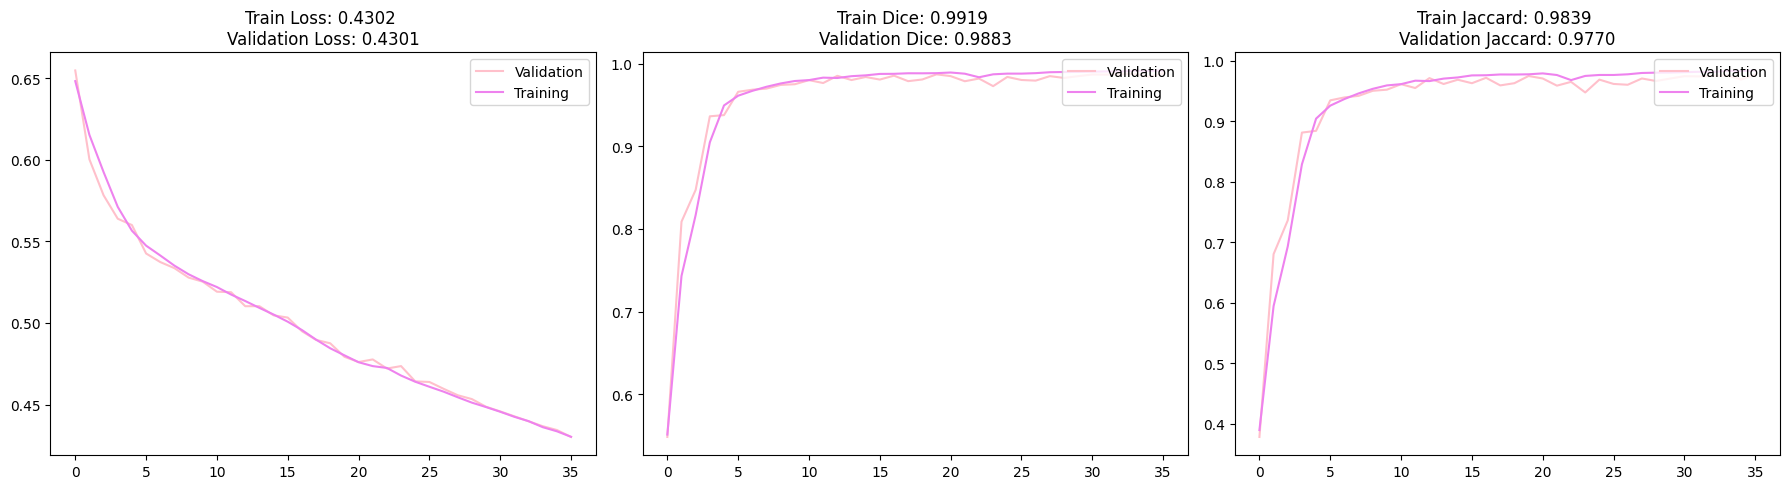

train epoch 37/40: 100%|██████████| 38/38 [00:29<00:00,  1.28it/s]


Loss: 0.4275 | Dice: 0.9917 | IoU: 0.9836


val epoch 37/40: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Loss: 0.4278 | Dice: 0.9867 | IoU: 0.9738


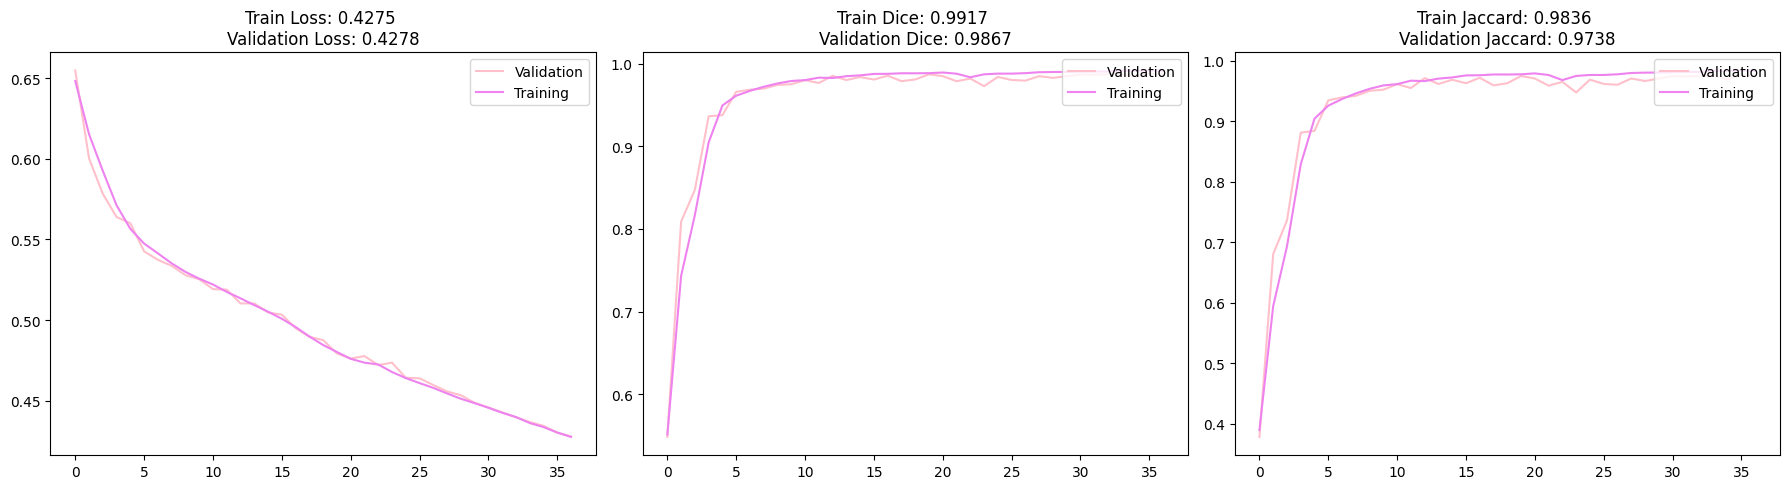

train epoch 38/40: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4251 | Dice: 0.9909 | IoU: 0.9820


val epoch 38/40: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Loss: 0.4241 | Dice: 0.9875 | IoU: 0.9755


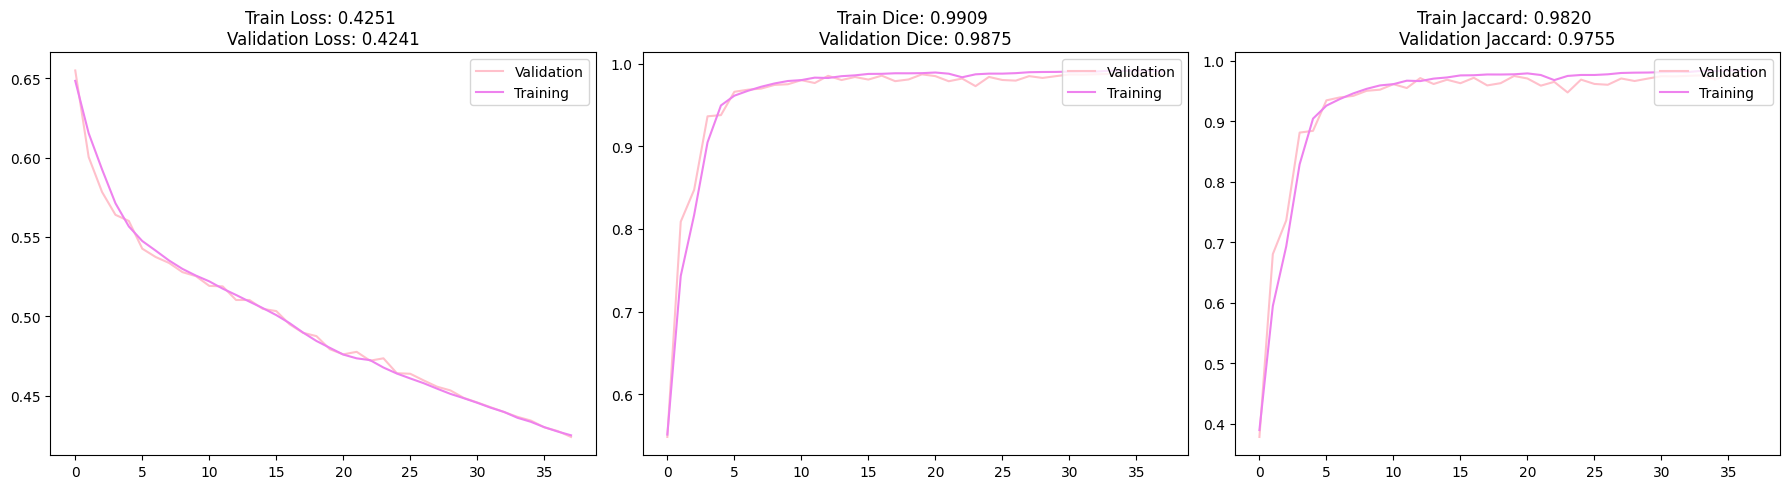

train epoch 39/40: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4215 | Dice: 0.9924 | IoU: 0.9850


val epoch 39/40: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Loss: 0.4233 | Dice: 0.9876 | IoU: 0.9756


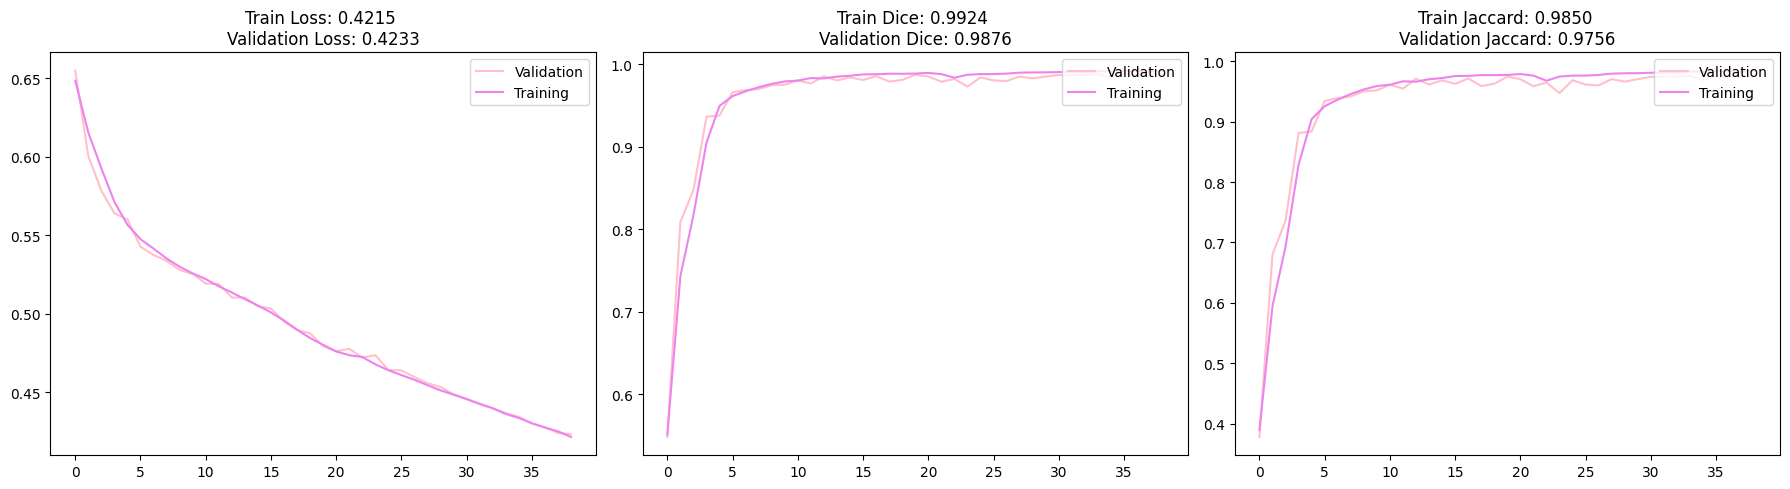

train epoch 40/40: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4184 | Dice: 0.9930 | IoU: 0.9862


val epoch 40/40: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Loss: 0.4224 | Dice: 0.9837 | IoU: 0.9682


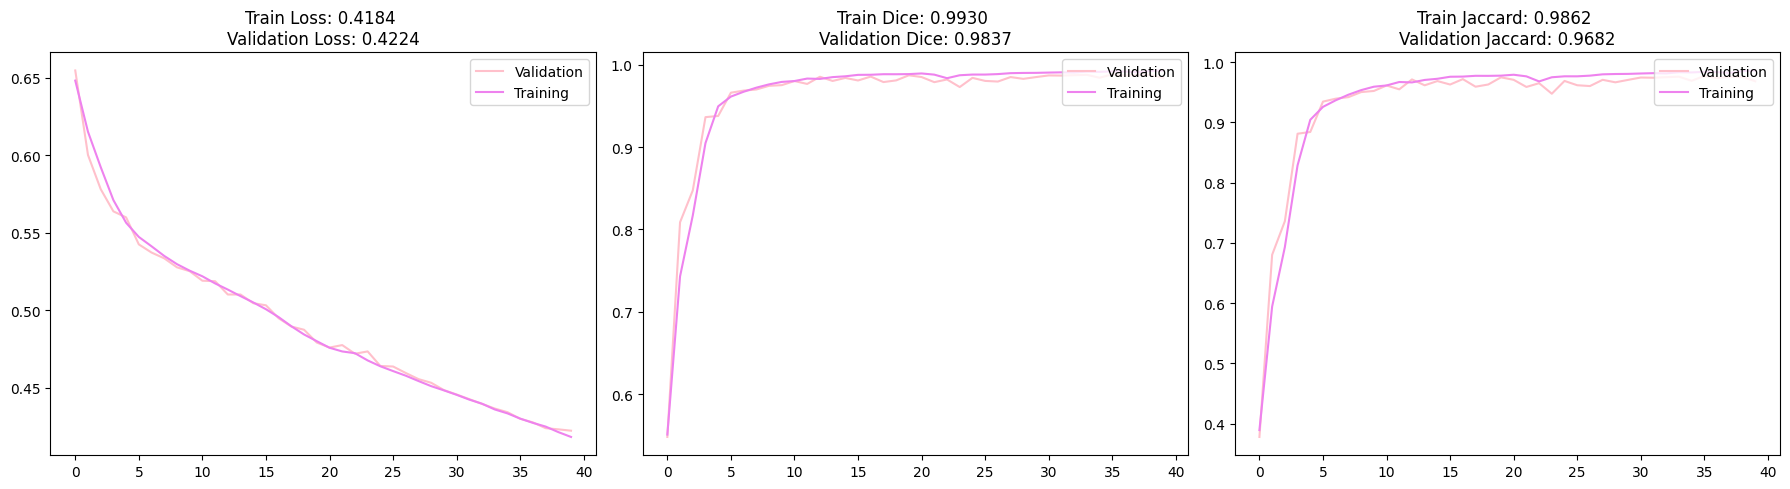


CPU times: user 17min 45s, sys: 50.7 s, total: 18min 35s
Wall time: 30min 8s


In [24]:
%%time
trainer.run()

In [32]:
def coef_metric_per_classes(probabilities, truth, threshold=0.5, eps=1e-9, classes=['WT', 'TC', 'ET', 'BG'], metric='dice'):
    scores = {key: [] for key in classes}
    predictions = (probabilities >= threshold).astype(np.float32)

    for i in range(probabilities.shape[0]):
        for class_, class_name in enumerate(classes):
            prediction = predictions[i, class_]
            truth_ = truth[i, class_]

            if metric == 'dice':
                intersection = 2.0 * np.sum(truth_ * prediction)
                union = np.sum(truth_) + np.sum(prediction)
            elif metric == 'jaccard':
                intersection = np.sum(prediction * truth_)
                union = np.sum(prediction) + np.sum(truth_) - intersection + eps
            else:
                raise ValueError("Unsupported metric. Use 'dice' or 'jaccard'.")

            if np.sum(truth_) == 0 and np.sum(prediction) == 0:
                scores[class_name].append(1.0)
            else:
                scores[class_name].append((intersection + eps) / (union + eps))

    return scores

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    loss_per_batch = []

    criterion = bce_dice_loss  # Use the appropriate loss function

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())

            # Compute loss
            loss = criterion(logits, targets, alpha=0.5, beta=0.5)
            loss_per_batch.append(loss.item())

            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = coef_metric_per_classes(logits, targets, metric='dice')
            iou_scores = coef_metric_per_classes(logits, targets, metric='jaccard')

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    average_loss = sum(loss_per_batch) / len(loss_per_batch)

    return average_loss, dice_scores_per_classes, iou_scores_per_classes

In [33]:
model.eval();

In [34]:
average_test_loss, dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, test_dl, ['WT', 'TC', 'ET', 'BG'])

print(f"Average Test Loss: {average_test_loss:.4f}\n")

for key in dice_scores_per_classes.keys():
    print(f"Average Test Dice ({key}): {np.mean(dice_scores_per_classes[key]):.4f}")
print("\t")
for key in iou_scores_per_classes.keys():
    print(f"Average Test Jaccard ({key}): {np.mean(iou_scores_per_classes[key]):.4f}")

Average Test Loss: 0.4220

Average Test Dice (WT): 0.8889
Average Test Dice (TC): 0.7472
Average Test Dice (ET): 1.0000
Average Test Dice (BG): 0.9849
	
Average Test Jaccard (WT): 0.8889
Average Test Jaccard (TC): 0.6328
Average Test Jaccard (ET): 1.0000
Average Test Jaccard (BG): 0.9703


In [35]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
test_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
test_metics_df = test_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
test_metics_df.sample(5)

WT dice    WT jaccard   TC dice  TC jaccard  ET dice  ET jaccard  \
9   1.000000e+00  1.000000e+00  0.161426    0.087799      1.0         1.0   
30  9.708738e-12  9.708738e-12  0.905179    0.826782      1.0         1.0   
3   3.333333e-10  3.333333e-10  0.843708    0.729666      1.0         1.0   
2   1.000000e+00  1.000000e+00  0.940851    0.888308      1.0         1.0   
17  1.000000e+00  1.000000e+00  0.809249    0.679612      1.0         1.0   

     BG dice  BG jaccard  
9   0.988334    0.976937  
30  0.985451    0.971320  
3   0.990719    0.981608  
2   0.990353    0.980890  
17  0.992903    0.985905

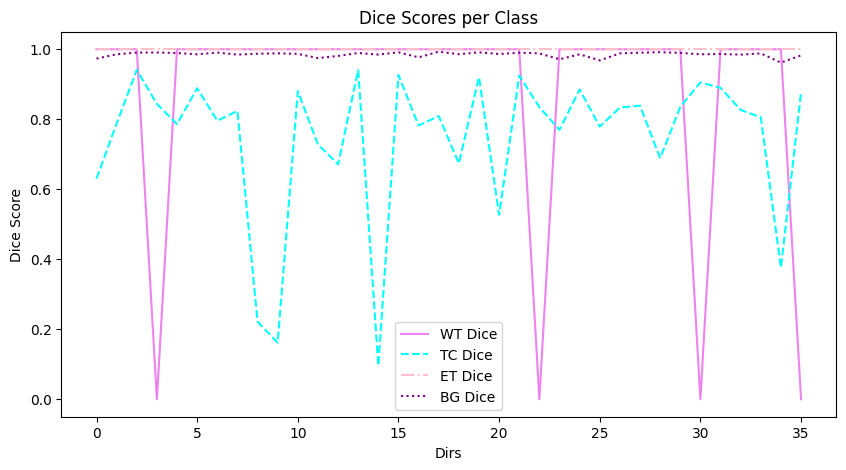

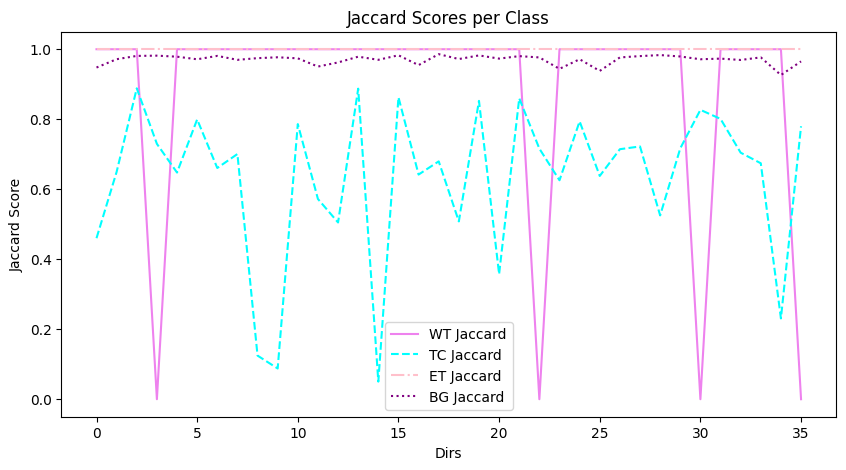

In [36]:
colors = ['violet', 'cyan', 'pink', 'purple']
linestyles = ['-', '--', '-.', ':']

# Plot the Dice scores
plt.figure(figsize=(10, 5))
for i, key in enumerate(dice_scores_per_classes.keys()):
    plt.plot(dice_scores_per_classes[key], label=f'{key} Dice', color=colors[i], linestyle=linestyles[i])
plt.title('Dice Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

# Plot the Jaccard scores
plt.figure(figsize=(10, 5))
for i, key in enumerate(iou_scores_per_classes.keys()):
    plt.plot(iou_scores_per_classes[key], label=f'{key} Jaccard', color=colors[i], linestyle=linestyles[i])
plt.title('Jaccard Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Jaccard Score')
plt.legend()
plt.show()

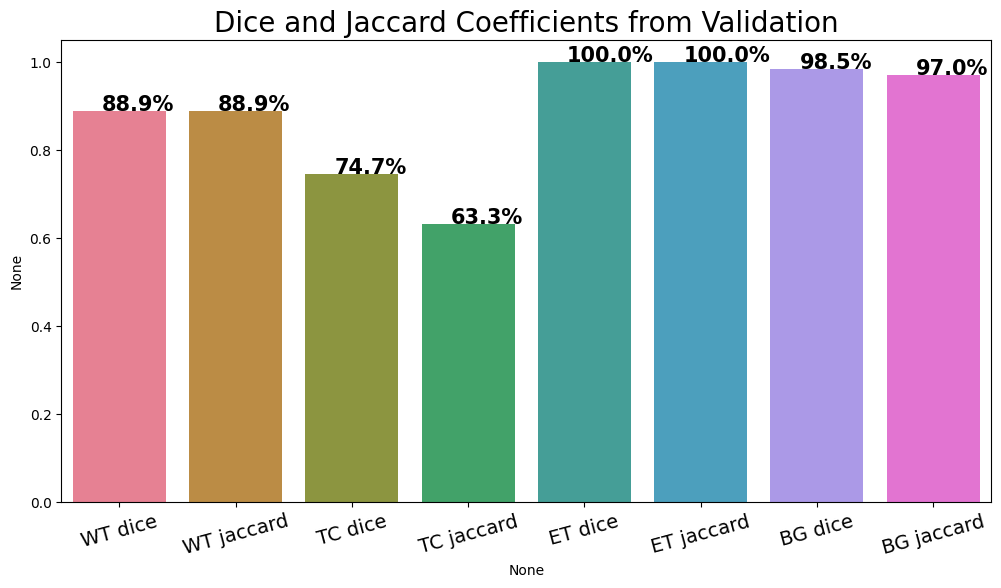

In [37]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = test_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=test_metics_df.mean().index, y=test_metics_df.mean(), hue=test_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(test_metics_df.mean().index)))
ax.set_xticklabels(test_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * test_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

plt.show()

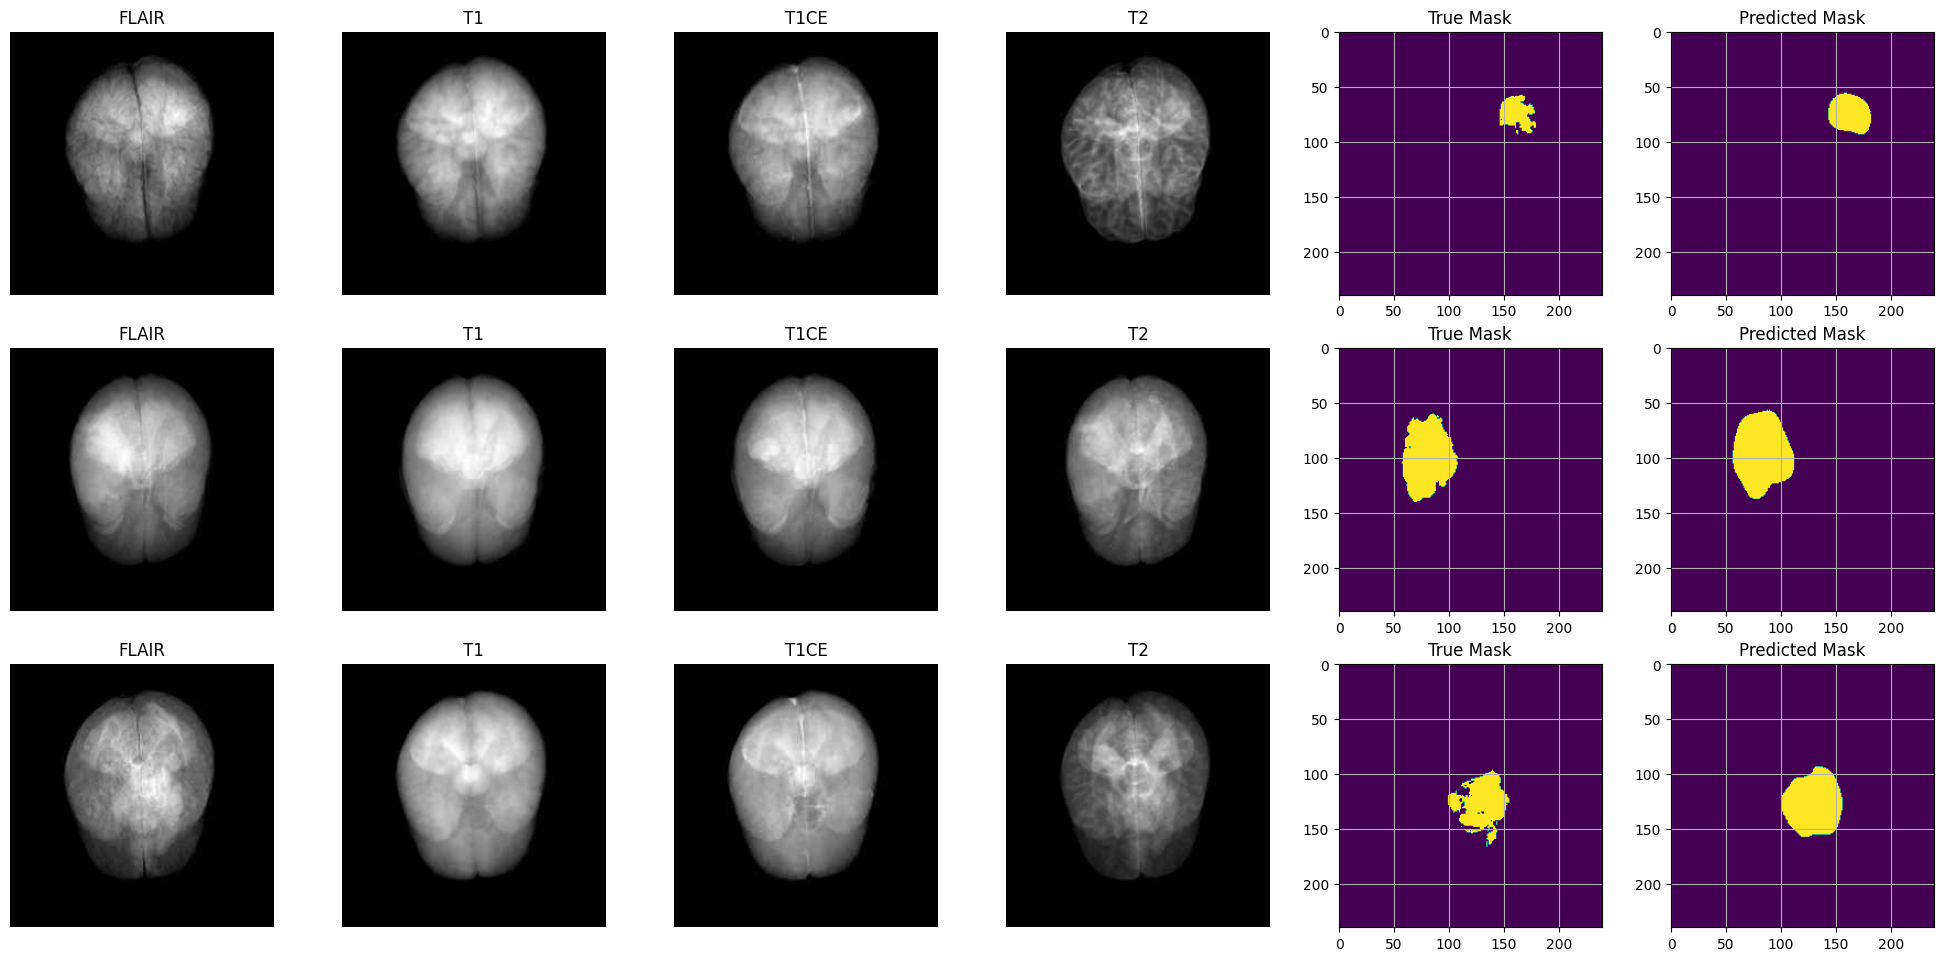

In [46]:
def show_results(model, test_dl):
    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images.float())

    preds = torch.argmax(outputs, dim=1)
    masks = torch.argmax(masks, dim=1)

    plt.figure(figsize=(25, 65))

    for i in range(3):
        for j in range(len(modality_types)):
            plt.subplot(16, 6, 6 * i + j + 1)
            plt.axis('off')
            plt.title(modality_types[j])
            plt.imshow(images[i][j].cpu(), cmap='gray')

        plt.subplot(16, 6, 6 * i + 5)
        plt.title('True Mask')
        plt.grid()
        plt.imshow(255 - masks[i].cpu(), cmap='viridis')

        plt.subplot(16, 6, 6 * i + 6)
        plt.title('Predicted Mask')
        plt.grid()
        plt.imshow(255 - preds[i].cpu(), cmap='viridis')

    plt.show()

show_results(model, test_dl)